In [1]:
# Import các thư viện cần thiết
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from mlxtend.frequent_patterns import apriori, association_rules
import scipy.stats as stats

# Đọc dữ liệu
df = pd.read_csv('Mobiles_Dataset_(2025).csv', encoding='latin1')

# Kiểm tra cấu trúc dữ liệu
print("Thông tin cơ bản về dữ liệu:")
print(f"Số lượng bản ghi: {df.shape[0]}")
print(f"Số lượng thuộc tính: {df.shape[1]}")
print("\nDanh sách các cột:")
print(df.columns.tolist())
print("\nXem 5 dòng đầu tiên:")
print(df.head())

Thông tin cơ bản về dữ liệu:
Số lượng bản ghi: 930
Số lượng thuộc tính: 15

Danh sách các cột:
['Company Name', 'Model Name', 'Mobile Weight', 'RAM', 'Front Camera', 'Back Camera', 'Processor', 'Battery Capacity', 'Screen Size', 'Launched Price (Pakistan)', 'Launched Price (India)', 'Launched Price (China)', 'Launched Price (USA)', 'Launched Price (Dubai)', 'Launched Year']

Xem 5 dòng đầu tiên:
  Company Name            Model Name Mobile Weight  RAM Front Camera  \
0        Apple       iPhone 16 128GB          174g  6GB         12MP   
1        Apple       iPhone 16 256GB          174g  6GB         12MP   
2        Apple       iPhone 16 512GB          174g  6GB         12MP   
3        Apple  iPhone 16 Plus 128GB          203g  6GB         12MP   
4        Apple  iPhone 16 Plus 256GB          203g  6GB         12MP   

  Back Camera   Processor Battery Capacity Screen Size  \
0        48MP  A17 Bionic         3,600mAh  6.1 inches   
1        48MP  A17 Bionic         3,600mAh  6.1 inch

In [2]:
# Thông tin cơ bản về dữ liệu
print("Thông tin chi tiết về kiểu dữ liệu:")
df.info()

# Thống kê mô tả cho dữ liệu số
print("\nThống kê mô tả cho dữ liệu số:")
print(df.describe())

# Kiểm tra giá trị null
print("\nKiểm tra giá trị null trong từng cột:")
print(df.isnull().sum())

Thông tin chi tiết về kiểu dữ liệu:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 930 entries, 0 to 929
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Company Name               930 non-null    object
 1   Model Name                 930 non-null    object
 2   Mobile Weight              930 non-null    object
 3   RAM                        930 non-null    object
 4   Front Camera               930 non-null    object
 5   Back Camera                930 non-null    object
 6   Processor                  930 non-null    object
 7   Battery Capacity           930 non-null    object
 8   Screen Size                930 non-null    object
 9   Launched Price (Pakistan)  930 non-null    object
 10  Launched Price (India)     930 non-null    object
 11  Launched Price (China)     930 non-null    object
 12  Launched Price (USA)       930 non-null    object
 13  Launched Price (Dubai)     93

In [3]:
# Tạo bản sao của DataFrame để tránh ảnh hưởng đến dữ liệu gốc
df_processed = df.copy()

# Kiểm tra tên các cột để xác định cấu trúc chính xác
print("Tên các cột trong dữ liệu:")
print(df_processed.columns.tolist())

# Xem một số giá trị đặc biệt trong các cột để hiểu cấu trúc dữ liệu
print("\nMột số giá trị RAM:")
print(df_processed['RAM'].value_counts().head(10))

# Xử lý dữ liệu trọng lượng (loại bỏ 'g' và chuyển thành số)
if 'Mobile Weight' in df_processed.columns:
    # Xử lý các trường hợp đặc biệt trước
    df_processed['Weight_g'] = df_processed['Mobile Weight'].str.replace('g', '')
    # Chuyển đổi an toàn sang float
    df_processed['Weight_g'] = pd.to_numeric(df_processed['Weight_g'], errors='coerce')

# Xử lý dữ liệu RAM (loại bỏ 'GB' và chuyển thành số)
if 'RAM' in df_processed.columns:
    # Xử lý các trường hợp đặc biệt như '8 / 12'
    # Lấy giá trị đầu tiên nếu có dấu '/'
    df_processed['RAM_clean'] = df_processed['RAM'].str.split('/').str[0].str.strip()
    # Loại bỏ 'GB'
    df_processed['RAM_clean'] = df_processed['RAM_clean'].str.replace('GB', '')
    # Chuyển đổi an toàn sang float
    df_processed['RAM_GB'] = pd.to_numeric(df_processed['RAM_clean'], errors='coerce')
    # Xóa cột tạm
    df_processed.drop('RAM_clean', axis=1, inplace=True)

# Xử lý dữ liệu camera (loại bỏ 'MP' và chuyển thành số)
if 'Front Camera' in df_processed.columns:
    # Xử lý các trường hợp đặc biệt
    df_processed['Front_Camera_clean'] = df_processed['Front Camera'].str.replace('MP', '')
    # Lấy giá trị đầu tiên nếu có nhiều giá trị (ví dụ: "10MP, 4MP")
    df_processed['Front_Camera_clean'] = df_processed['Front_Camera_clean'].str.split(',').str[0].str.strip()
    # Chuyển đổi an toàn sang float
    df_processed['Front_Camera_MP'] = pd.to_numeric(df_processed['Front_Camera_clean'], errors='coerce')
    # Xóa cột tạm
    df_processed.drop('Front_Camera_clean', axis=1, inplace=True)

if 'Back Camera' in df_processed.columns:
    # Xử lý các trường hợp đặc biệt
    df_processed['Back_Camera_clean'] = df_processed['Back Camera'].str.replace('MP', '')
    # Lấy giá trị đầu tiên nếu có nhiều giá trị
    df_processed['Back_Camera_clean'] = df_processed['Back_Camera_clean'].str.split(',').str[0].str.strip()
    # Chuyển đổi an toàn sang float
    df_processed['Back_Camera_MP'] = pd.to_numeric(df_processed['Back_Camera_clean'], errors='coerce')
    # Xóa cột tạm
    df_processed.drop('Back_Camera_clean', axis=1, inplace=True)

# Xử lý dữ liệu pin (loại bỏ 'mAh' và chuyển thành số)
if 'Battery Capacity' in df_processed.columns:
    # Xử lý các trường hợp đặc biệt
    df_processed['Battery_clean'] = df_processed['Battery Capacity'].str.replace('mAh', '')
    # Chuyển đổi an toàn sang float
    df_processed['Battery_mAh'] = pd.to_numeric(df_processed['Battery_clean'], errors='coerce')
    # Xóa cột tạm
    df_processed.drop('Battery_clean', axis=1, inplace=True)

# Xử lý dữ liệu màn hình (loại bỏ 'inches' và chuyển thành số)
if 'Screen Size' in df_processed.columns:
    # Xử lý các trường hợp đặc biệt
    df_processed['Screen_Size_clean'] = df_processed['Screen Size'].str.replace('inches', '').str.strip()
    # Chuyển đổi an toàn sang float
    df_processed['Screen_inches'] = pd.to_numeric(df_processed['Screen_Size_clean'], errors='coerce')
    # Xóa cột tạm
    df_processed.drop('Screen_Size_clean', axis=1, inplace=True)

# Xử lý dữ liệu giá (loại bỏ các ký tự không phải số và chuyển thành số)
# Chuyển đổi giá từ chuỗi sang số
price_pk = pd.to_numeric(df_processed['Launched Price (Pakistan)'].str.replace('PKR', '').str.replace(',', '').str.strip(), errors='coerce')
df_processed['Price_PKR'] = price_pk

# Hiển thị dữ liệu sau khi xử lý
print("\nDữ liệu sau khi xử lý:")
print(df_processed.head())
print("\nCác cột mới sau khi xử lý:")
print(df_processed.columns.tolist())

# Kiểm tra các giá trị NaN sau khi xử lý
print("\nSố lượng giá trị NaN trong mỗi cột:")
print(df_processed.isnull().sum())

Tên các cột trong dữ liệu:
['Company Name', 'Model Name', 'Mobile Weight', 'RAM', 'Front Camera', 'Back Camera', 'Processor', 'Battery Capacity', 'Screen Size', 'Launched Price (Pakistan)', 'Launched Price (India)', 'Launched Price (China)', 'Launched Price (USA)', 'Launched Price (Dubai)', 'Launched Year']

Một số giá trị RAM:
RAM
8GB           308
6GB           206
12GB          193
4GB           146
3GB            34
16GB           31
2GB             6
1.5GB           2
8GB / 12GB      2
10GB            1
Name: count, dtype: int64

Dữ liệu sau khi xử lý:
  Company Name            Model Name Mobile Weight  RAM Front Camera  \
0        Apple       iPhone 16 128GB          174g  6GB         12MP   
1        Apple       iPhone 16 256GB          174g  6GB         12MP   
2        Apple       iPhone 16 512GB          174g  6GB         12MP   
3        Apple  iPhone 16 Plus 128GB          203g  6GB         12MP   
4        Apple  iPhone 16 Plus 256GB          203g  6GB         12MP   

  B

Số lượng giá trị NaN trong các cột quan trọng trước khi điền:
Battery_mAh: 615 giá trị thiếu (66.13%)
RAM_GB: 0 giá trị thiếu (0.00%)
Screen_inches: 8 giá trị thiếu (0.86%)
Front_Camera_MP: 47 giá trị thiếu (5.05%)
Back_Camera_MP: 417 giá trị thiếu (44.84%)
Price_PKR: 1 giá trị thiếu (0.11%)

Số lượng giá trị NaN sau khi điền:

Điền theo nhóm:
Battery_mAh: 0 giá trị thiếu
RAM_GB: 0 giá trị thiếu
Screen_inches: 0 giá trị thiếu
Front_Camera_MP: 0 giá trị thiếu
Back_Camera_MP: 0 giá trị thiếu
Price_PKR: 1 giá trị thiếu

KNN Imputer:
Battery_mAh: 0 giá trị thiếu
RAM_GB: 0 giá trị thiếu
Screen_inches: 0 giá trị thiếu
Front_Camera_MP: 0 giá trị thiếu
Back_Camera_MP: 0 giá trị thiếu
Price_PKR: 0 giá trị thiếu

MICE Imputer:
Battery_mAh: 0 giá trị thiếu
RAM_GB: 0 giá trị thiếu
Screen_inches: 0 giá trị thiếu
Front_Camera_MP: 0 giá trị thiếu
Back_Camera_MP: 0 giá trị thiếu
Price_PKR: 0 giá trị thiếu

Thống kê mô tả sau khi điền giá trị thiếu:
        Battery_mAh      RAM_GB  Screen_inches  Front

/var/folders/r3/8pdlj8l94ds3x1q25cvsmhhm0000gn/T/ipykernel_39708/2743652404.py:27: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_imputed_mean[col].fillna(group_means[col], inplace=True)
/var/folders/r3/8pdlj8l94ds3x1q25cvsmhhm0000gn/T/ipykernel_39708/2743652404.py:29: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are settin

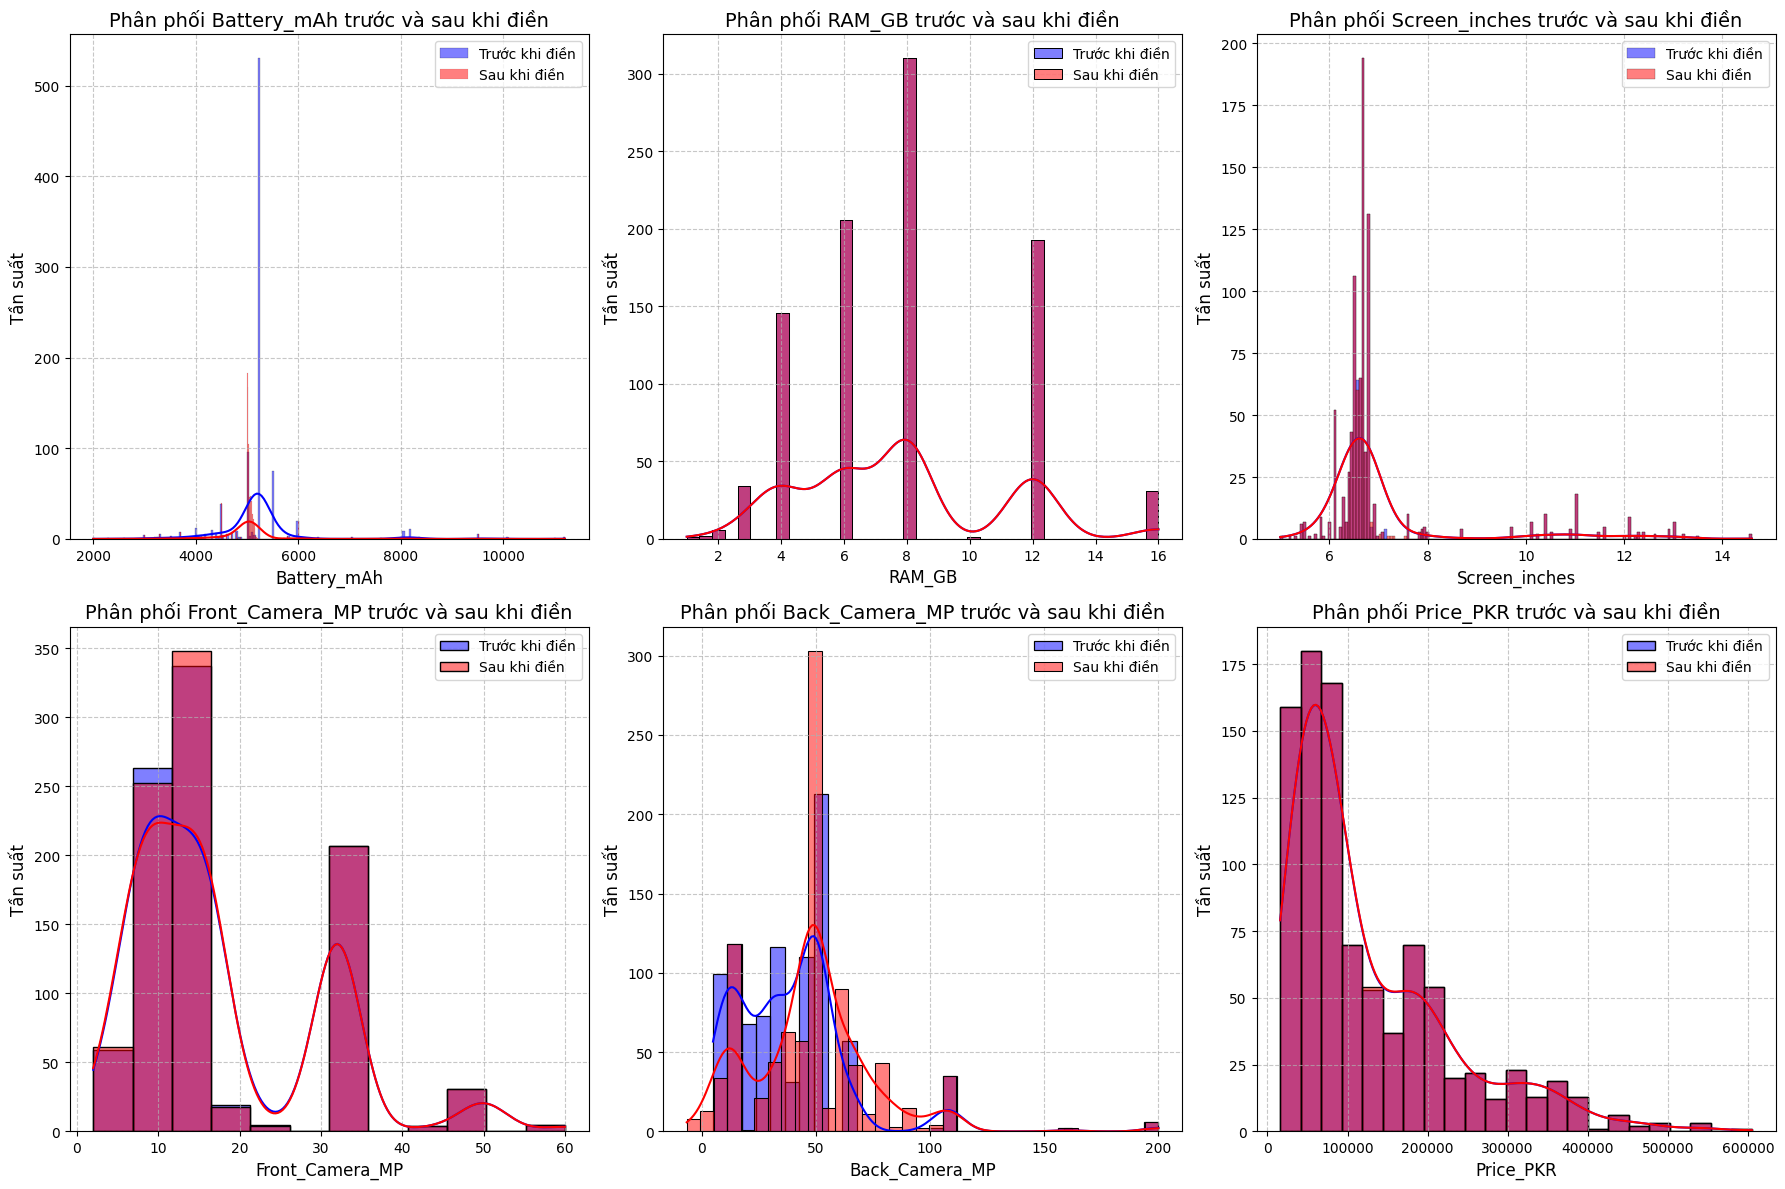

In [4]:
# Điền giá trị thiếu trong dữ liệu
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

print("Số lượng giá trị NaN trong các cột quan trọng trước khi điền:")
for col in ['Battery_mAh', 'RAM_GB', 'Screen_inches', 'Front_Camera_MP', 'Back_Camera_MP', 'Price_PKR']:
    if col in df_processed.columns:
        print(f"{col}: {df_processed[col].isna().sum()} giá trị thiếu ({df_processed[col].isna().sum() / len(df_processed) * 100:.2f}%)")

# Phương pháp 1: Điền bằng giá trị trung bình theo nhóm (hãng sản xuất)
df_imputed_mean = df_processed.copy()

# Tạo dictionary để lưu giá trị trung bình theo nhóm
group_means = {}
for col in ['Battery_mAh', 'RAM_GB', 'Screen_inches', 'Front_Camera_MP', 'Back_Camera_MP']:
    if col in df_imputed_mean.columns:
        # Tính giá trị trung bình theo hãng sản xuất
        group_means[col] = df_imputed_mean.groupby('Company Name')[col].transform('mean')

# Điền giá trị thiếu bằng giá trị trung bình theo nhóm
for col in ['Battery_mAh', 'RAM_GB', 'Screen_inches', 'Front_Camera_MP', 'Back_Camera_MP']:
    if col in df_imputed_mean.columns:
        # Điền giá trị thiếu bằng giá trị trung bình theo nhóm
        df_imputed_mean[col].fillna(group_means[col], inplace=True)
        # Nếu vẫn còn giá trị thiếu (do một số nhóm không có giá trị nào), điền bằng giá trị trung bình tổng thể
        df_imputed_mean[col].fillna(df_imputed_mean[col].mean(), inplace=True)

# Phương pháp 2: Sử dụng KNN Imputer
# Chọn các cột số để điền giá trị thiếu
numeric_cols = ['Battery_mAh', 'RAM_GB', 'Screen_inches', 'Front_Camera_MP', 'Back_Camera_MP', 'Price_PKR']
numeric_cols = [col for col in numeric_cols if col in df_processed.columns]

# Tạo bản sao của DataFrame
df_imputed_knn = df_processed.copy()

# Chuẩn bị dữ liệu cho KNN Imputer
X_incomplete = df_imputed_knn[numeric_cols].copy()

# Khởi tạo KNN Imputer
imputer = KNNImputer(n_neighbors=5)

# Điền giá trị thiếu
X_imputed = imputer.fit_transform(X_incomplete)

# Cập nhật DataFrame với giá trị đã điền
df_imputed_knn[numeric_cols] = X_imputed

# Phương pháp 3: Sử dụng Iterative Imputer (MICE)
# Tạo bản sao của DataFrame
df_imputed_mice = df_processed.copy()

# Chuẩn bị dữ liệu cho Iterative Imputer
X_incomplete = df_imputed_mice[numeric_cols].copy()

# Khởi tạo Iterative Imputer
mice_imputer = IterativeImputer(max_iter=10, random_state=42)

# Điền giá trị thiếu
X_imputed = mice_imputer.fit_transform(X_incomplete)

# Cập nhật DataFrame với giá trị đã điền
df_imputed_mice[numeric_cols] = X_imputed

# So sánh kết quả của các phương pháp điền giá trị thiếu
print("\nSố lượng giá trị NaN sau khi điền:")
for method, df_name in [("Điền theo nhóm", df_imputed_mean), ("KNN Imputer", df_imputed_knn), ("MICE Imputer", df_imputed_mice)]:
    print(f"\n{method}:")
    for col in numeric_cols:
        print(f"{col}: {df_name[col].isna().sum()} giá trị thiếu")

# Chọn phương pháp điền giá trị thiếu tốt nhất (ở đây chọn MICE vì thường cho kết quả tốt nhất)
df_processed = df_imputed_mice.copy()

print("\nThống kê mô tả sau khi điền giá trị thiếu:")
print(df_processed[numeric_cols].describe())

# Vẽ biểu đồ so sánh phân phối trước và sau khi điền giá trị thiếu
plt.figure(figsize=(18, 12))
for i, col in enumerate(numeric_cols):
    if i < 6:  # Giới hạn số lượng biểu đồ
        plt.subplot(2, 3, i+1)
        
        # Phân phối trước khi điền
        sns.histplot(df_imputed_mean[col].dropna(), kde=True, color='blue', alpha=0.5, label='Trước khi điền')
        
        # Phân phối sau khi điền
        sns.histplot(df_processed[col], kde=True, color='red', alpha=0.5, label='Sau khi điền')
        
        plt.title(f'Phân phối {col} trước và sau khi điền', fontsize=14)
        plt.xlabel(col, fontsize=12)
        plt.ylabel('Tần suất', fontsize=12)
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [5]:
# Tạo hàm phân tích chi tiết cho từng cột
def analyze_column(df, column_name):
    print(f"===== Phân tích cột: {column_name} =====")
    print(f"Kiểu dữ liệu: {df[column_name].dtype}")
    print(f"Số lượng giá trị null: {df[column_name].isnull().sum()}")
    print(f"Số lượng giá trị unique: {df[column_name].nunique()}")
    
    # Nếu là dữ liệu số
    if pd.api.types.is_numeric_dtype(df[column_name]):
        print(f"Mean: {df[column_name].mean()}")
        print(f"Median: {df[column_name].median()}")
        print(f"Mode: {df[column_name].mode()[0]}")
        print(f"Min: {df[column_name].min()}")
        print(f"Max: {df[column_name].max()}")
        print(f"Five-number summary:")
        print(df[column_name].quantile([0, 0.25, 0.5, 0.75, 1.0]))
        print(f"Midrange: {(df[column_name].min() + df[column_name].max()) / 2}")
    
    # Nếu là dữ liệu phân loại
    else:
        value_counts = df[column_name].value_counts()
        value_percentages = df[column_name].value_counts(normalize=True) * 100
        print("Phân bố giá trị:")
        for value, count, percentage in zip(value_counts.index, value_counts, value_percentages):
            print(f"  {value}: {count} ({percentage:.2f}%)")
        print(f"Mode: {df[column_name].mode()[0]}")
    
    print("\n")

# Phân tích các cột gốc quan trọng
original_columns = ['Company Name', 'Mobile Weight', 'RAM', 'Front Camera', 'Back Camera', 'Battery Capacity', 'Screen Size', 'Launched Year']
for column in original_columns:
    if column in df_processed.columns:
        analyze_column(df_processed, column)

# Phân tích các cột đã xử lý
processed_columns = ['Weight_g', 'RAM_GB', 'Front_Camera_MP', 'Back_Camera_MP', 'Battery_mAh', 'Screen_inches', 'Price_PKR']
for column in processed_columns:
    if column in df_processed.columns:
        analyze_column(df_processed, column)

===== Phân tích cột: Company Name =====
Kiểu dữ liệu: object
Số lượng giá trị null: 0
Số lượng giá trị unique: 19
Phân bố giá trị:
  Oppo: 129 (13.87%)
  Apple: 97 (10.43%)
  Honor: 91 (9.78%)
  Samsung: 88 (9.46%)
  Vivo: 86 (9.25%)
  Realme: 69 (7.42%)
  Motorola: 62 (6.67%)
  Infinix: 56 (6.02%)
  OnePlus: 53 (5.70%)
  Huawei: 42 (4.52%)
  Tecno: 39 (4.19%)
  POCO: 30 (3.23%)
  Xiaomi: 27 (2.90%)
  Google: 21 (2.26%)
  Lenovo: 15 (1.61%)
  Nokia: 11 (1.18%)
  Sony: 9 (0.97%)
  iQOO: 3 (0.32%)
  Poco: 2 (0.22%)
Mode: Oppo


===== Phân tích cột: Mobile Weight =====
Kiểu dữ liệu: object
Số lượng giá trị null: 0
Số lượng giá trị unique: 148
Phân bố giá trị:
  190g: 68 (7.31%)
  195g: 64 (6.88%)
  185g: 29 (3.12%)
  192g: 26 (2.80%)
  180g: 25 (2.69%)
  205g: 22 (2.37%)
  186g: 22 (2.37%)
  198g: 22 (2.37%)
  206g: 21 (2.26%)
  188g: 21 (2.26%)
  191g: 20 (2.15%)
  189g: 20 (2.15%)
  210g: 18 (1.94%)
  199g: 18 (1.94%)
  203g: 17 (1.83%)
  184g: 16 (1.72%)
  196g: 16 (1.72%)
  202g: 15 (

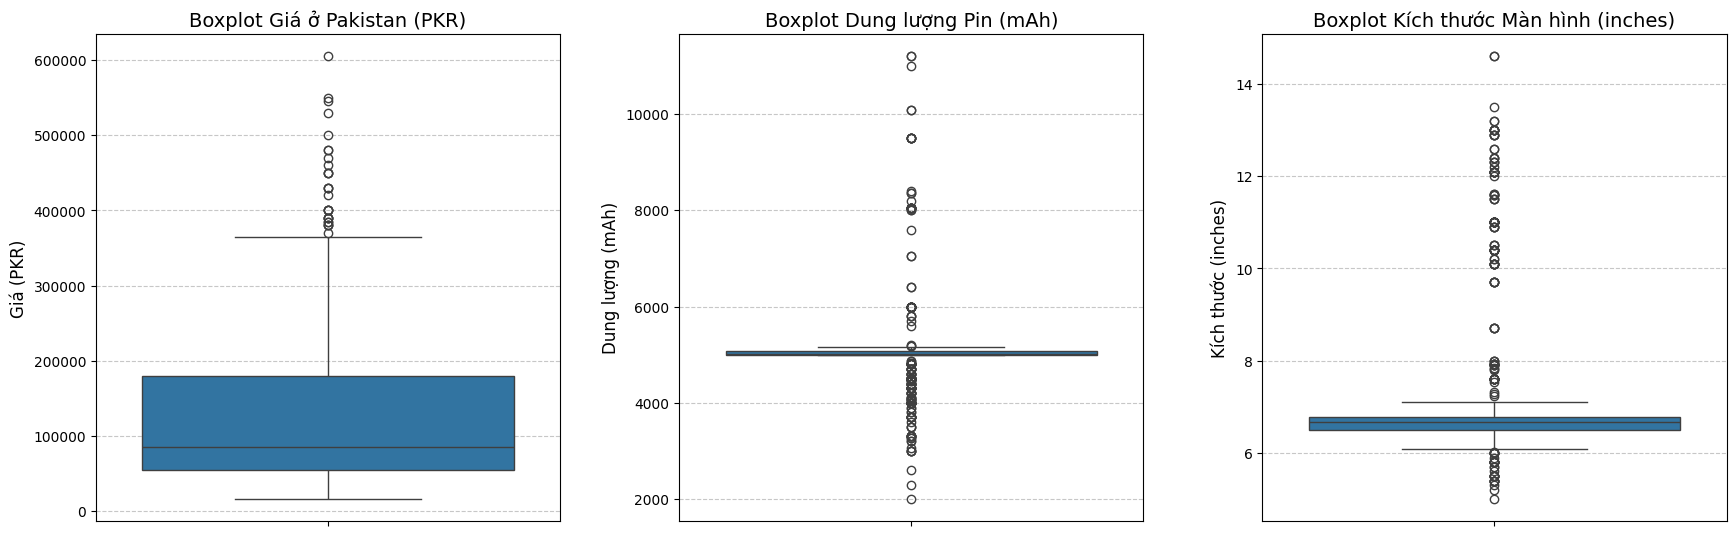

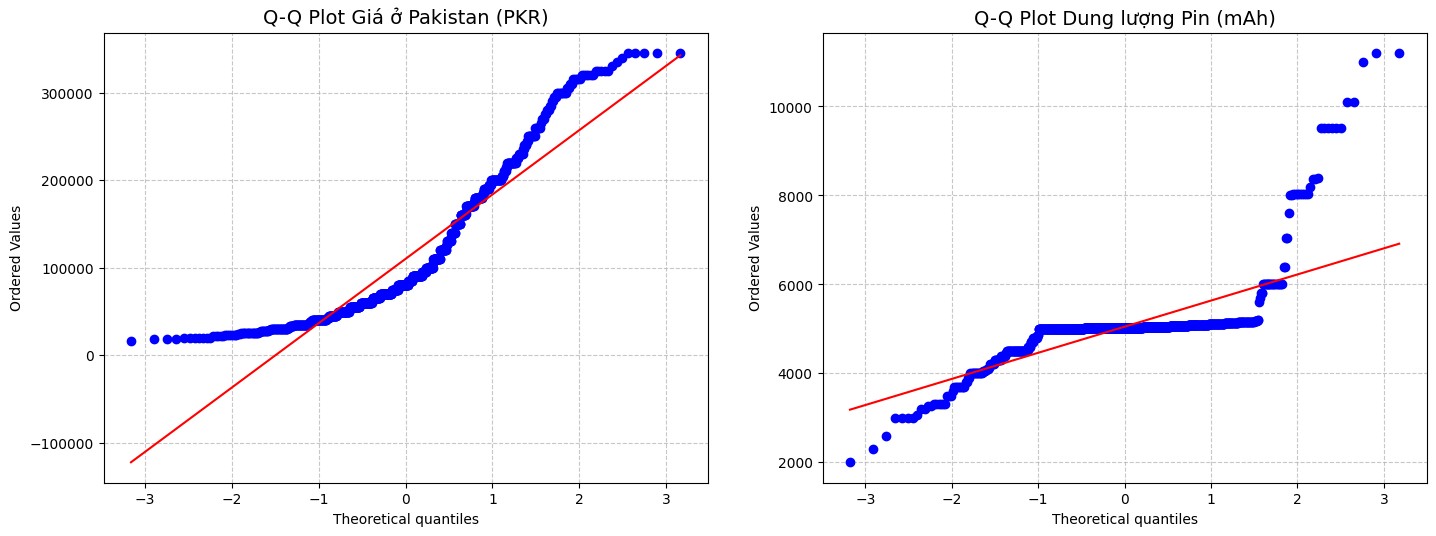

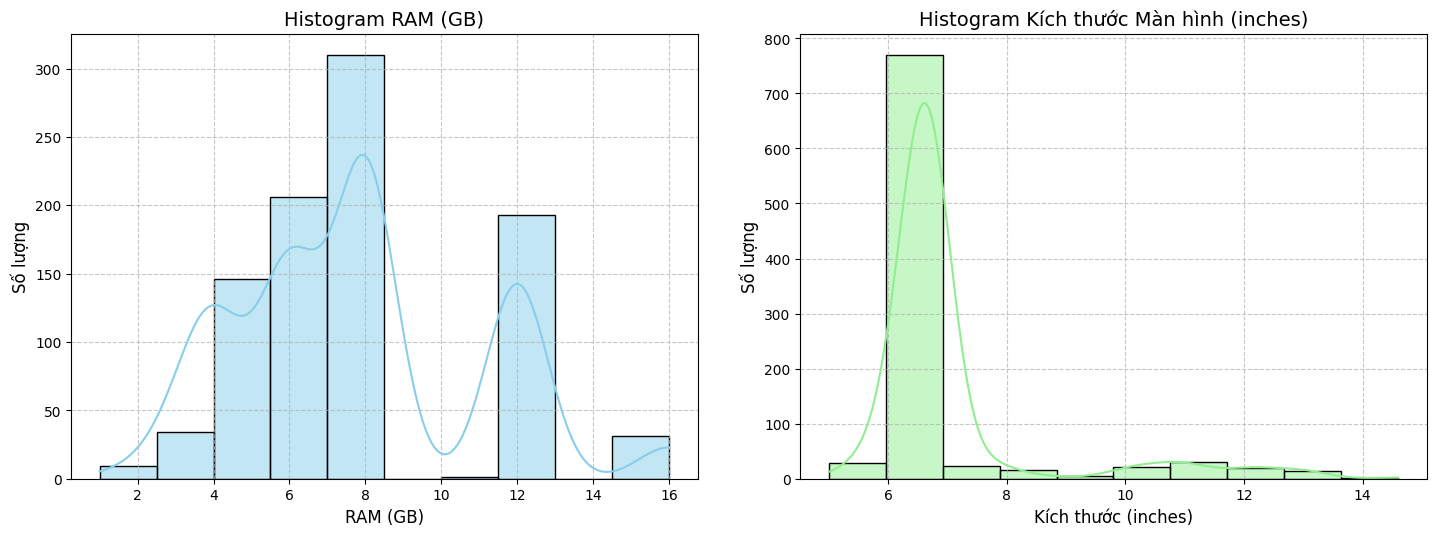

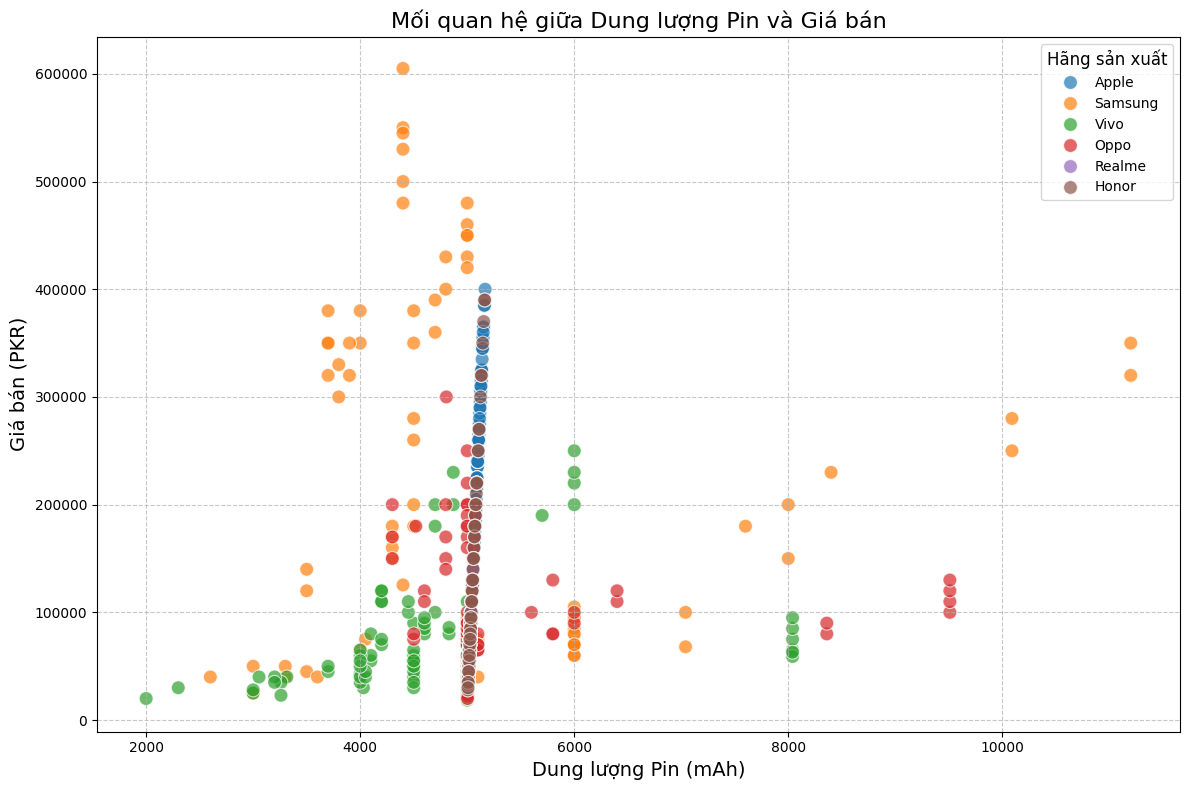

In [6]:
# Tối ưu lại code vẽ boxplot
plt.figure(figsize=(18, 6))

# Vẽ boxplot cho giá ở Pakistan
plt.subplot(1, 3, 1)
sns.boxplot(y=df_processed['Price_PKR'])
plt.title('Boxplot Giá ở Pakistan (PKR)', fontsize=14)
plt.ylabel('Giá (PKR)', fontsize=12)
plt.ticklabel_format(style='plain', axis='y')  # Tắt ký hiệu khoa học
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Vẽ boxplot cho dung lượng pin
plt.subplot(1, 3, 2)
sns.boxplot(y=df_processed['Battery_mAh'])
plt.title('Boxplot Dung lượng Pin (mAh)', fontsize=14)
plt.ylabel('Dung lượng (mAh)', fontsize=12)
plt.ticklabel_format(style='plain', axis='y')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Vẽ boxplot cho kích thước màn hình
plt.subplot(1, 3, 3)
sns.boxplot(y=df_processed['Screen_inches'])
plt.title('Boxplot Kích thước Màn hình (inches)', fontsize=14)
plt.ylabel('Kích thước (inches)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout(pad=3.0)
plt.show()

# Vẽ Q-Q Plot cho 2 thuộc tính
plt.figure(figsize=(15, 6))

# Q-Q Plot cho giá
plt.subplot(1, 2, 1)
# Loại bỏ các giá trị ngoại lai để Q-Q plot rõ ràng hơn
price_pk_clean = df_processed['Price_PKR'][df_processed['Price_PKR'] < df_processed['Price_PKR'].quantile(0.95)]
stats.probplot(price_pk_clean, dist="norm", plot=plt)
plt.title('Q-Q Plot Giá ở Pakistan (PKR)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)

# Q-Q Plot cho dung lượng pin
plt.subplot(1, 2, 2)
stats.probplot(df_processed['Battery_mAh'], dist="norm", plot=plt)
plt.title('Q-Q Plot Dung lượng Pin (mAh)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout(pad=3.0)
plt.show()

# Vẽ Histogram cho 2 thuộc tính
plt.figure(figsize=(15, 6))

# Histogram cho RAM
plt.subplot(1, 2, 1)
sns.histplot(df_processed['RAM_GB'].dropna(), kde=True, bins=10, color='skyblue')
plt.title('Histogram RAM (GB)', fontsize=14)
plt.xlabel('RAM (GB)', fontsize=12)
plt.ylabel('Số lượng', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Histogram cho kích thước màn hình
plt.subplot(1, 2, 2)
sns.histplot(df_processed['Screen_inches'].dropna(), kde=True, bins=10, color='lightgreen')
plt.title('Histogram Kích thước Màn hình (inches)', fontsize=14)
plt.xlabel('Kích thước (inches)', fontsize=12)
plt.ylabel('Số lượng', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout(pad=3.0)
plt.show()

# Vẽ Scatter plot cho mối quan hệ giữa dung lượng pin và giá
plt.figure(figsize=(12, 8))
# Tạo DataFrame tạm thời với dữ liệu đã chuyển đổi
temp_df = pd.DataFrame({
    'Battery (mAh)': df_processed['Battery_mAh'],
    'Price (PKR)': df_processed['Price_PKR'],
    'Company': df_processed['Company Name']
})
# Loại bỏ các hàng có giá trị NaN
temp_df = temp_df.dropna()
# Giới hạn số lượng hãng hiển thị để tránh quá tải
top_companies = temp_df['Company'].value_counts().nlargest(6).index
temp_df_filtered = temp_df[temp_df['Company'].isin(top_companies)]

# Vẽ scatter plot
sns.scatterplot(x='Battery (mAh)', y='Price (PKR)', hue='Company', data=temp_df_filtered, s=100, alpha=0.7)
plt.title('Mối quan hệ giữa Dung lượng Pin và Giá bán', fontsize=16)
plt.xlabel('Dung lượng Pin (mAh)', fontsize=14)
plt.ylabel('Giá bán (PKR)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(title='Hãng sản xuất', title_fontsize=12, fontsize=10)
plt.ticklabel_format(style='plain', axis='y')  # Tắt ký hiệu khoa học

plt.tight_layout()
plt.show()

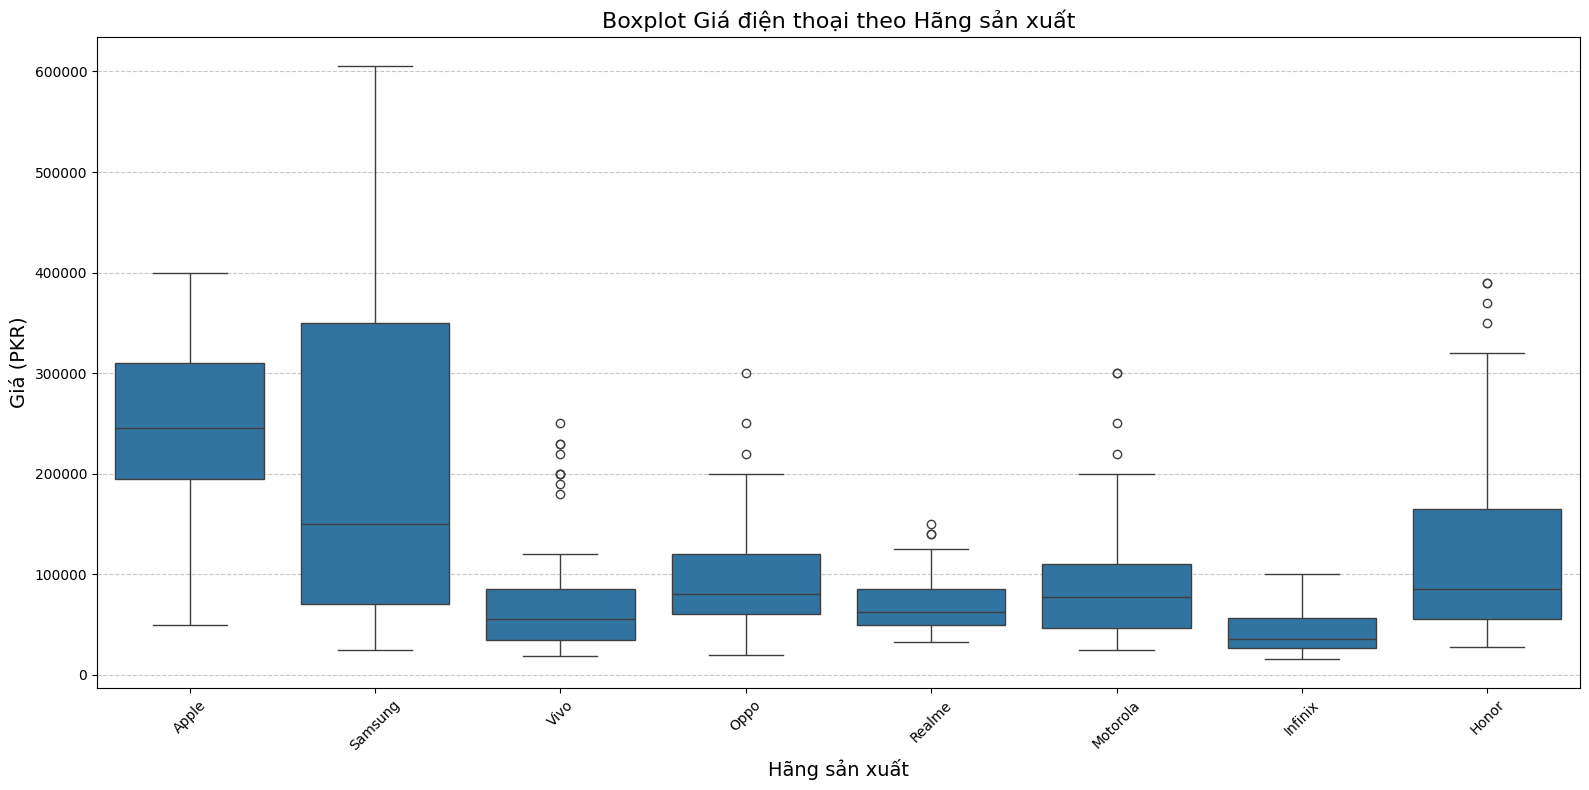

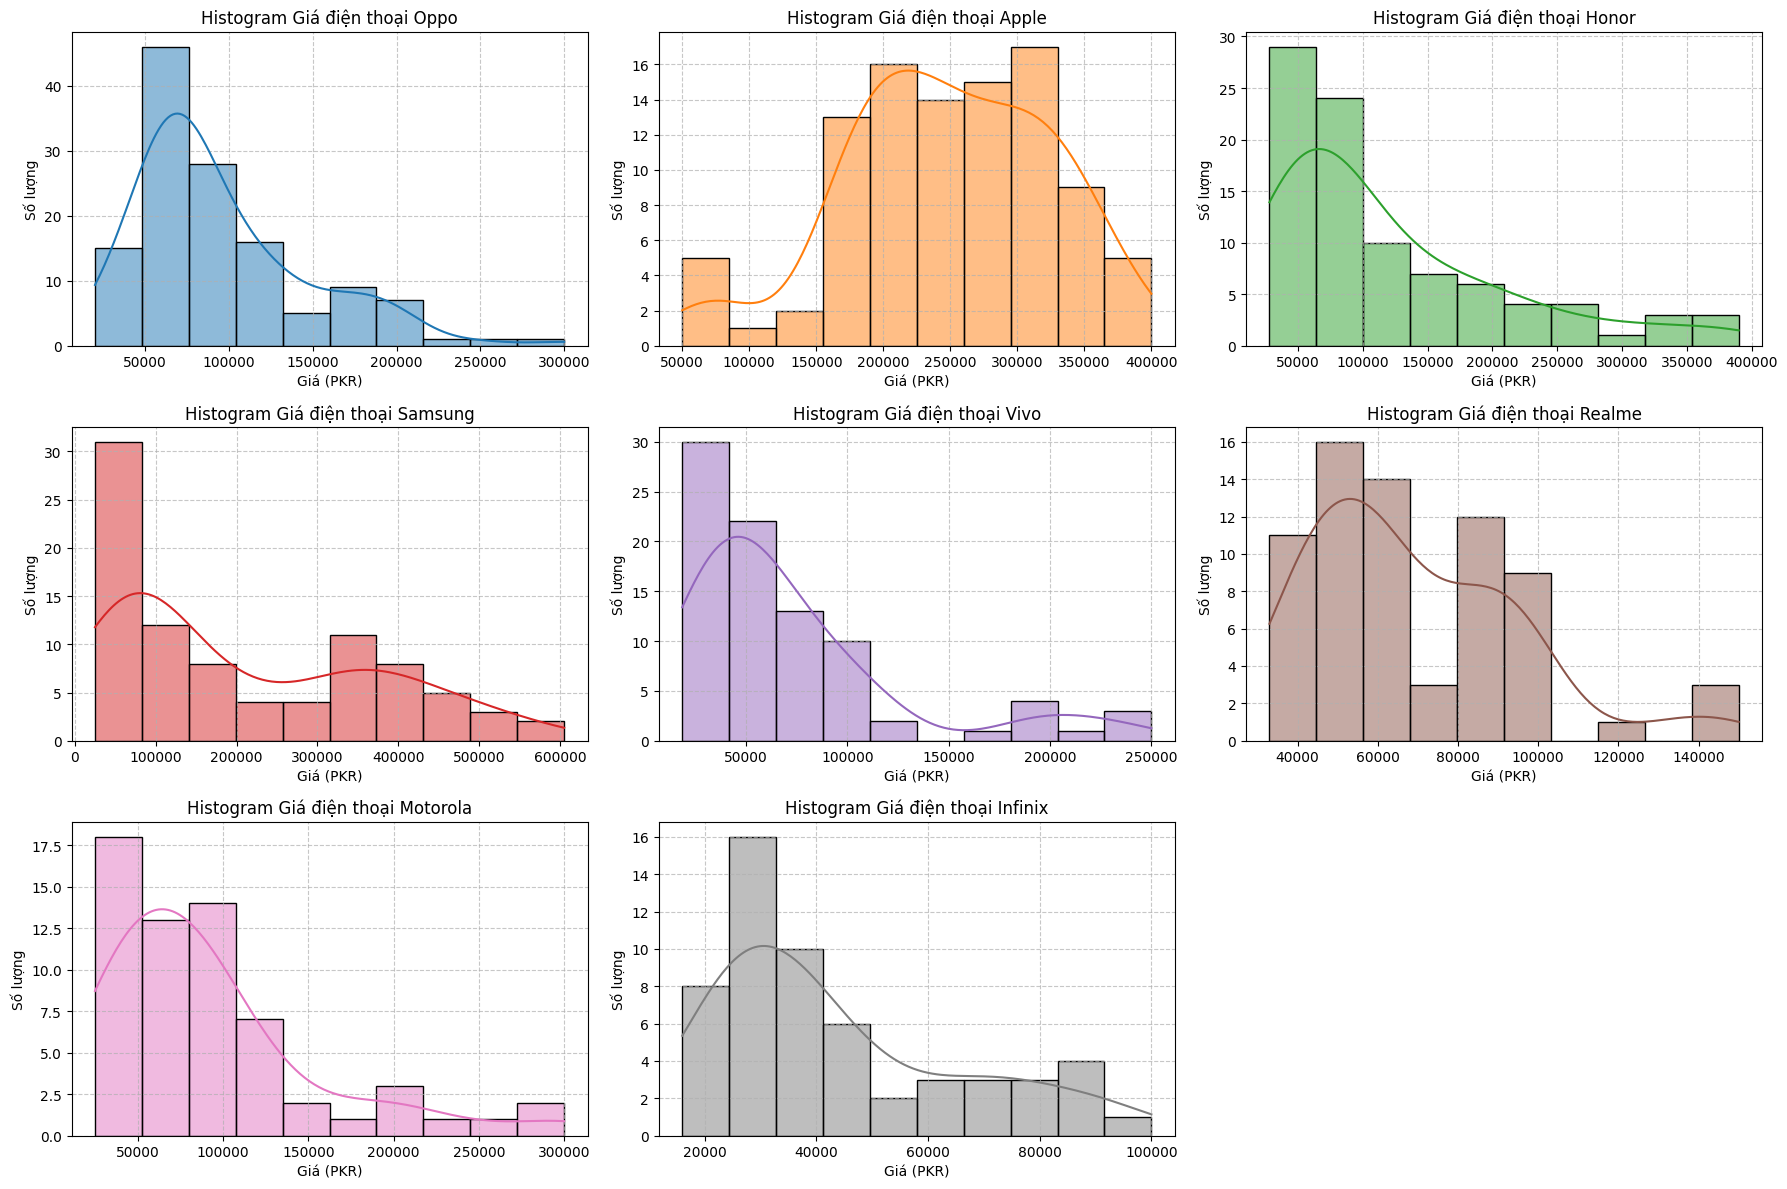

In [7]:
# Nhóm dữ liệu theo hãng sản xuất và vẽ boxplot
plt.figure(figsize=(16, 8))

# Lấy top 8 hãng phổ biến nhất để tránh đồ thị quá rối
top_companies = df_processed['Company Name'].value_counts().nlargest(8).index
df_top = df_processed[df_processed['Company Name'].isin(top_companies)]

# Vẽ boxplot giá theo hãng
sns.boxplot(x='Company Name', y='Price_PKR', data=df_top)
plt.title('Boxplot Giá điện thoại theo Hãng sản xuất', fontsize=16)
plt.xlabel('Hãng sản xuất', fontsize=14)
plt.ylabel('Giá (PKR)', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ticklabel_format(style='plain', axis='y')

plt.tight_layout()
plt.show()

# Vẽ histogram giá theo hãng
plt.figure(figsize=(18, 12))
for i, company in enumerate(top_companies):
    plt.subplot(3, 3, i+1)
    company_data = df_processed[df_processed['Company Name'] == company]
    sns.histplot(company_data['Price_PKR'].dropna(), kde=True, bins=10, color=plt.cm.tab10(i))
    plt.title(f'Histogram Giá điện thoại {company}', fontsize=12)
    plt.xlabel('Giá (PKR)', fontsize=10)
    plt.ylabel('Số lượng', fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.ticklabel_format(style='plain', axis='x')

plt.tight_layout()
plt.show()

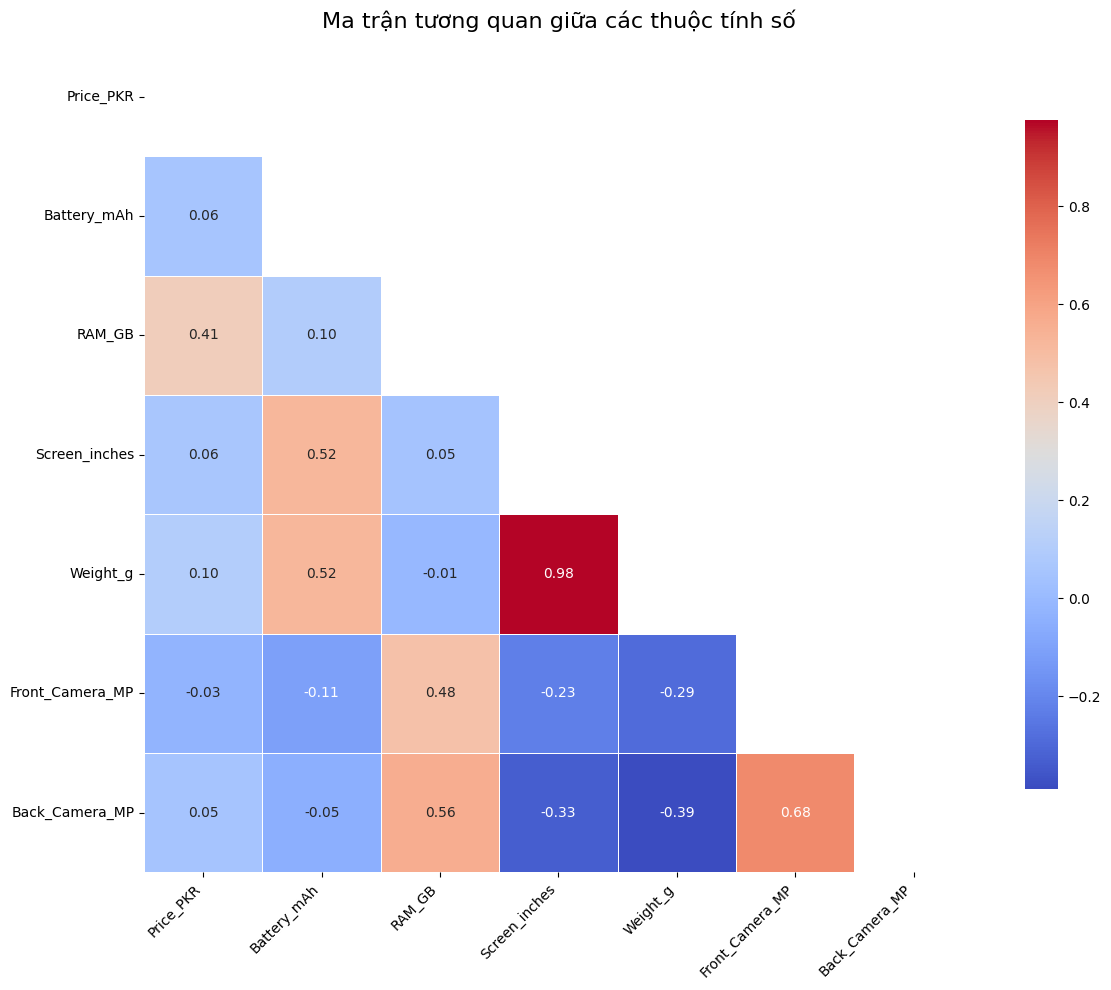

Dữ liệu mẫu cho tính toán độ tương đồng Cosin:
   Price_PKR  Battery_mAh  RAM_GB  Screen_inches  Weight_g  Front_Camera_MP  \
0   224999.0  5091.527260     6.0            6.1     174.0             12.0   
1   234999.0  5095.849709     6.0            6.1     174.0             12.0   
2   244999.0  5100.172159     6.0            6.1     174.0             12.0   
3   249999.0  5102.333384     6.0            6.7     203.0             12.0   

   Back_Camera_MP  
0            48.0  
1            48.0  
2            48.0  
3            48.0  


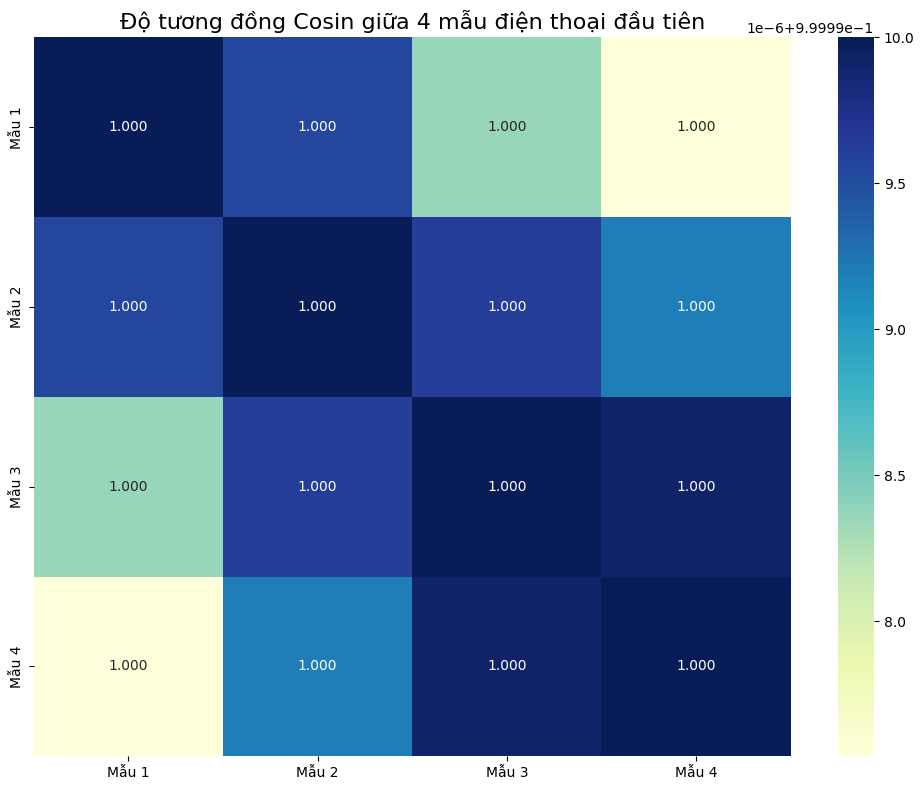

In [8]:
# Chuẩn bị dữ liệu cho phân tích tương quan
# Tạo thuộc tính nhị phân: Điện thoại mới (2023-2025) hay cũ
df_processed['is_latest'] = (pd.to_numeric(df_processed['Launched Year'], errors='coerce') >= 2023).astype(int)

# Tạo thuộc tính thứ tự: Phân loại RAM
df_processed['RAM_category'] = pd.cut(df_processed['RAM_GB'], 
                           bins=[0, 4, 8, 12, 20], 
                           labels=['Low', 'Medium', 'High', 'Ultra'])

# Ma trận tương quan cho dữ liệu số
numeric_columns = ['Price_PKR', 'Battery_mAh', 'RAM_GB', 'Screen_inches', 'Weight_g', 'Front_Camera_MP', 'Back_Camera_MP']
numeric_df = df_processed[numeric_columns].dropna()

# Vẽ ma trận tương quan
plt.figure(figsize=(12, 10))
correlation_matrix = numeric_df.corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))  # Tạo mask để chỉ hiển thị nửa dưới
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', mask=mask, 
            linewidths=0.5, cbar_kws={"shrink": .8})
plt.title('Ma trận tương quan giữa các thuộc tính số', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Độ đo Cosin
from sklearn.metrics.pairwise import cosine_similarity

# Chọn 4 dòng dữ liệu đầu tiên
sample_data = numeric_df.head(4)

# Hiển thị dữ liệu mẫu
print("Dữ liệu mẫu cho tính toán độ tương đồng Cosin:")
print(sample_data)

# Tính độ tương đồng cosin
cosine_sim = cosine_similarity(sample_data)

plt.figure(figsize=(10, 8))
sns.heatmap(cosine_sim, annot=True, cmap='YlGnBu', fmt='.3f',
            xticklabels=[f"Mẫu {i+1}" for i in range(len(sample_data))], 
            yticklabels=[f"Mẫu {i+1}" for i in range(len(sample_data))])
plt.title('Độ tương đồng Cosin giữa 4 mẫu điện thoại đầu tiên', fontsize=16)
plt.tight_layout()
plt.show()

In [9]:
# Tổng hợp dữ liệu theo hãng sản xuất
company_summary = df_processed.groupby('Company Name').agg({
    'Price_PKR': ['mean', 'median', 'min', 'max', 'count'],
    'Battery_mAh': ['mean', 'median', 'min', 'max', 'count'],
    'RAM_GB': ['mean', 'median', 'min', 'max', 'count'],
    'Screen_inches': ['mean', 'median', 'min', 'max', 'count']
}).round(2)

# Hiển thị kết quả tổng hợp cho top 10 hãng có nhiều mẫu nhất
top10_companies = df_processed['Company Name'].value_counts().nlargest(10).index
print("Tổng hợp dữ liệu theo hãng sản xuất (Top 10 hãng phổ biến):")
print(company_summary.loc[top10_companies])

# Tổng hợp dữ liệu theo năm ra mắt
year_summary = df_processed.groupby('Launched Year').agg({
    'Price_PKR': ['mean', 'median', 'min', 'max', 'count'],
    'Battery_mAh': ['mean', 'median', 'min', 'max', 'count'],
    'RAM_GB': ['mean', 'median', 'min', 'max', 'count'],
    'Screen_inches': ['mean', 'median', 'min', 'max', 'count']
}).round(2)

print("\nTổng hợp dữ liệu theo năm ra mắt:")
print(year_summary)

Tổng hợp dữ liệu theo hãng sản xuất (Top 10 hãng phổ biến):
              Price_PKR                                    Battery_mAh  \
                   mean    median      min       max count        mean   
Company Name                                                             
Oppo           94867.22   79999.0  19999.0  299999.0   129     5230.26   
Apple         247627.87  244999.0  49999.0  399999.0    97     5101.31   
Honor         120174.82   84999.0  27999.0  389999.0    91     5046.22   
Samsung       208993.55  150000.0  25000.0  604999.0    88     5119.43   
Vivo           72405.98   54999.0  18499.0  249999.0    86     4678.60   
Realme         69158.42   61999.0  32999.0  149999.0    69     5024.17   
Motorola       91579.65   77499.0  24999.0  299999.0    62     5033.86   
Infinix        43909.71   35999.0  15999.0   99999.0    56     5013.25   
OnePlus       134810.36  149999.0  29999.0  299999.0    53     4840.38   
Huawei        183534.76  169999.0  79999.0  389999.0

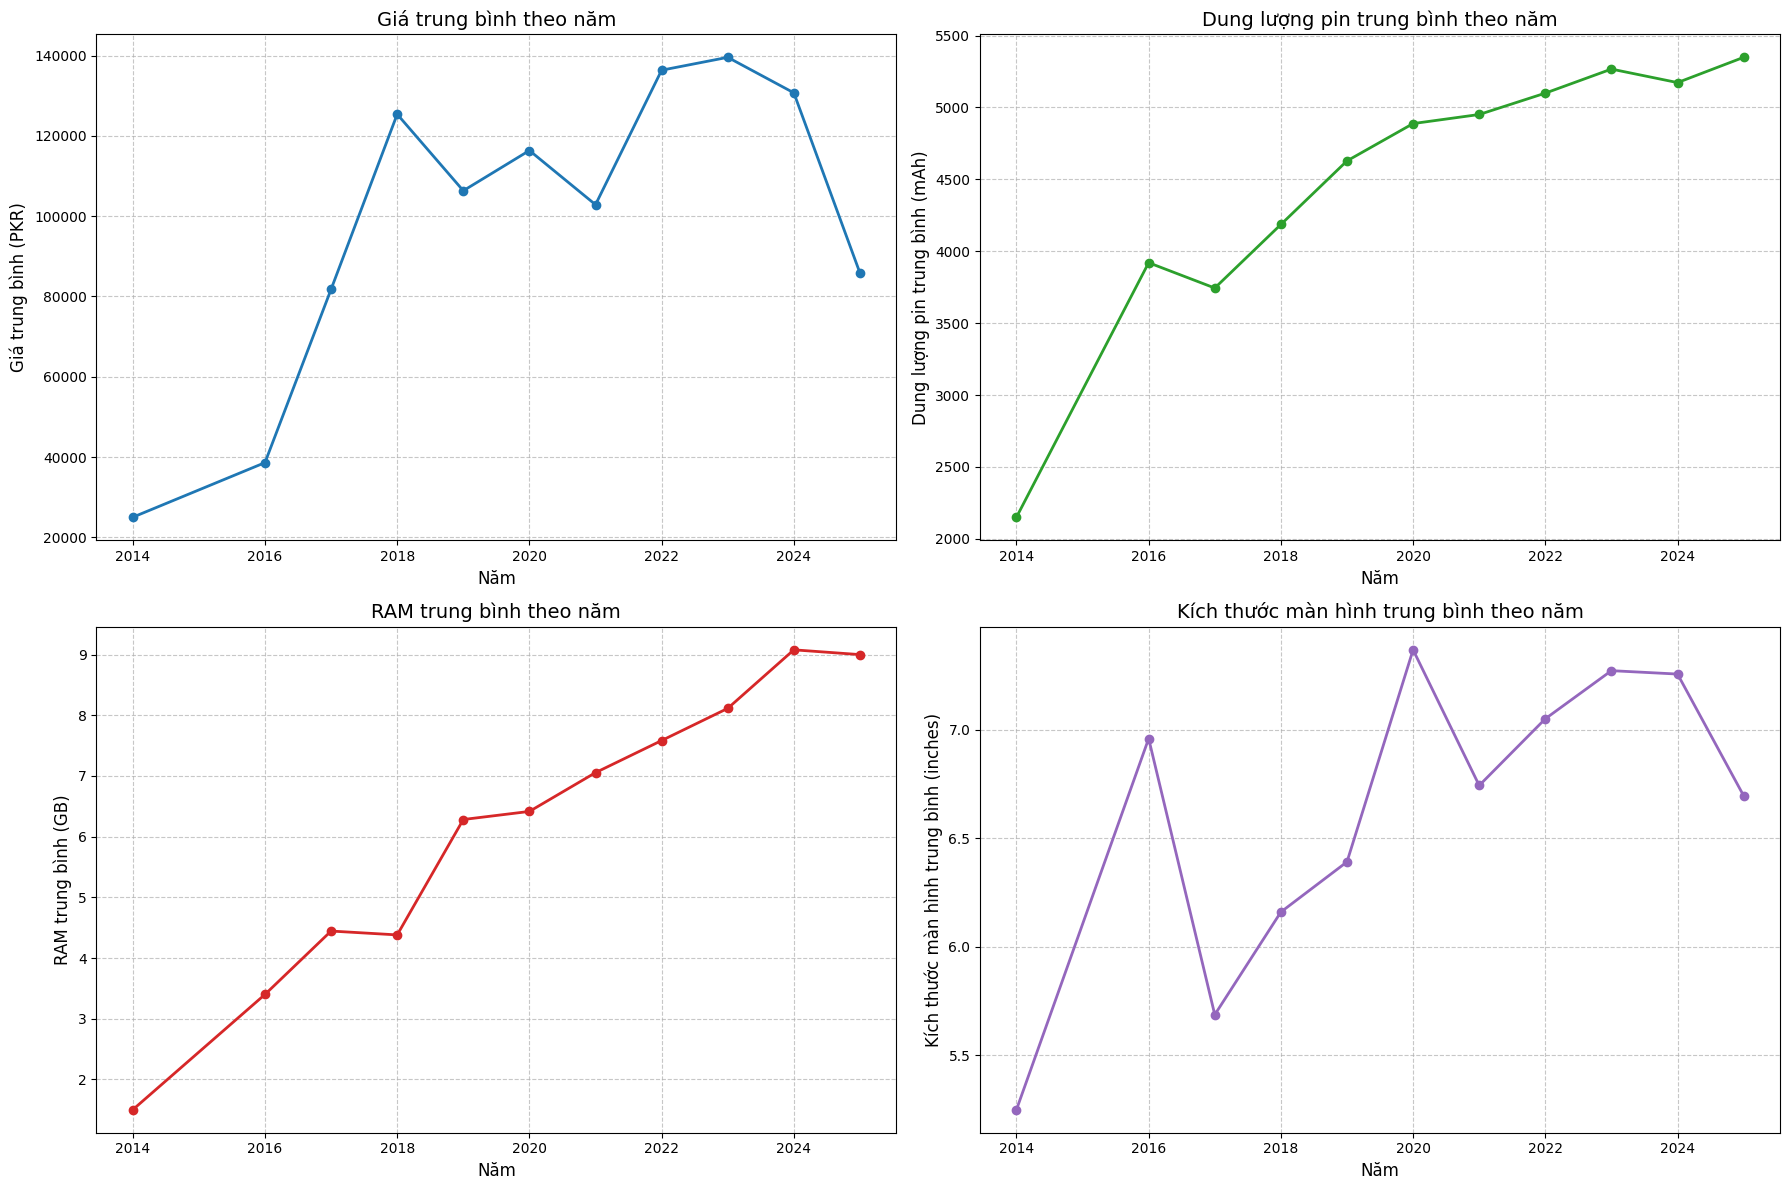

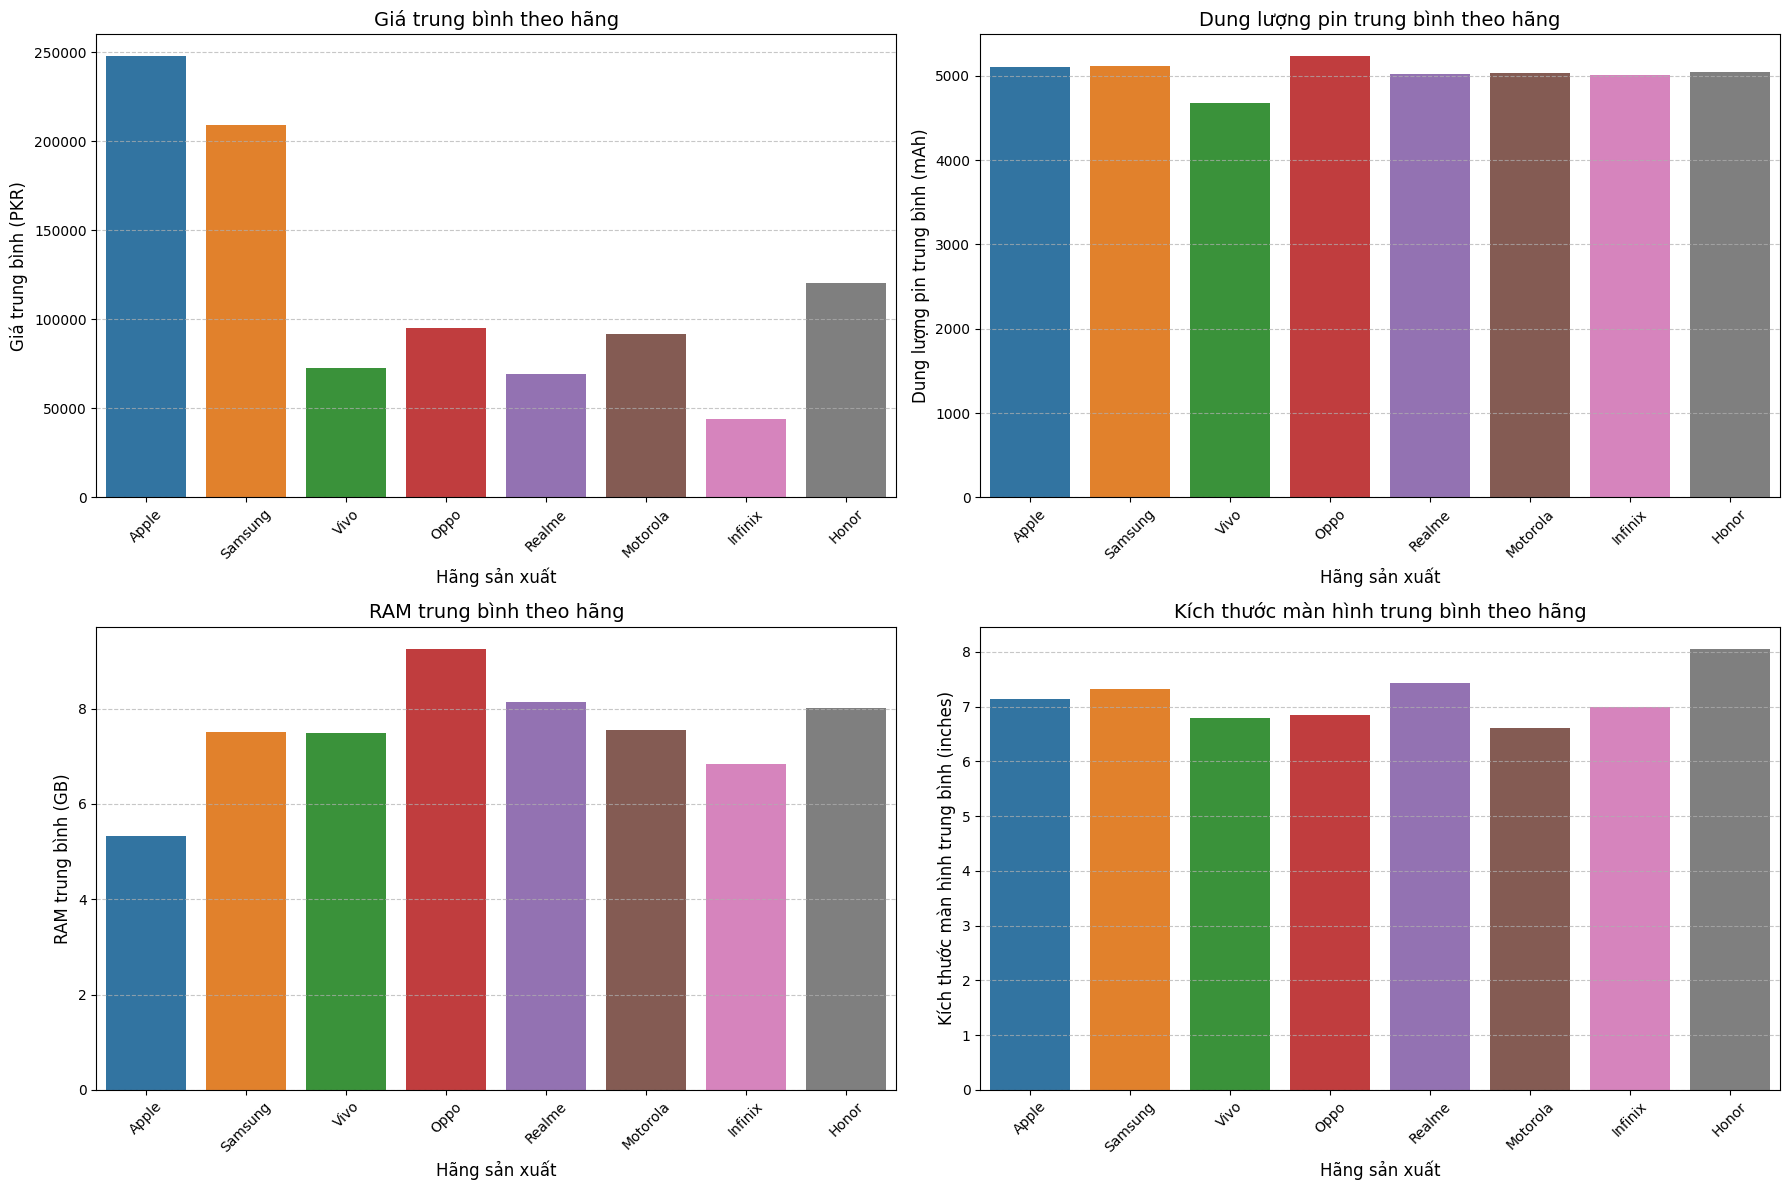

In [10]:
# Biểu đồ xu hướng theo năm
plt.figure(figsize=(18, 12))

# Chuyển đổi năm sang số
df_processed['Year_num'] = pd.to_numeric(df_processed['Launched Year'], errors='coerce')

# Lọc dữ liệu hợp lệ
valid_years = df_processed.dropna(subset=['Year_num', 'Price_PKR', 'Battery_mAh', 'RAM_GB', 'Screen_inches'])
# Nhóm theo năm và tính trung bình
year_data = valid_years.groupby('Year_num').agg({
    'Price_PKR': 'mean',
    'Battery_mAh': 'mean',
    'RAM_GB': 'mean',
    'Screen_inches': 'mean'
})

# Vẽ biểu đồ xu hướng giá theo năm
plt.subplot(2, 2, 1)
plt.plot(year_data.index, year_data['Price_PKR'], marker='o', linewidth=2, color='#1f77b4')
plt.title('Giá trung bình theo năm', fontsize=14)
plt.xlabel('Năm', fontsize=12)
plt.ylabel('Giá trung bình (PKR)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.ticklabel_format(style='plain', axis='y')

# Vẽ biểu đồ xu hướng dung lượng pin theo năm
plt.subplot(2, 2, 2)
plt.plot(year_data.index, year_data['Battery_mAh'], marker='o', linewidth=2, color='#2ca02c')
plt.title('Dung lượng pin trung bình theo năm', fontsize=14)
plt.xlabel('Năm', fontsize=12)
plt.ylabel('Dung lượng pin trung bình (mAh)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Vẽ biểu đồ xu hướng RAM theo năm
plt.subplot(2, 2, 3)
plt.plot(year_data.index, year_data['RAM_GB'], marker='o', linewidth=2, color='#d62728')
plt.title('RAM trung bình theo năm', fontsize=14)
plt.xlabel('Năm', fontsize=12)
plt.ylabel('RAM trung bình (GB)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Vẽ biểu đồ xu hướng kích thước màn hình theo năm
plt.subplot(2, 2, 4)
plt.plot(year_data.index, year_data['Screen_inches'], marker='o', linewidth=2, color='#9467bd')
plt.title('Kích thước màn hình trung bình theo năm', fontsize=14)
plt.xlabel('Năm', fontsize=12)
plt.ylabel('Kích thước màn hình trung bình (inches)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# Biểu đồ so sánh giữa các hãng
plt.figure(figsize=(18, 12))

# Lấy top 8 hãng phổ biến nhất
top_companies = df_processed['Company Name'].value_counts().nlargest(8).index
df_top = df_processed[df_processed['Company Name'].isin(top_companies)]

# Vẽ biểu đồ so sánh giá trung bình theo hãng
plt.subplot(2, 2, 1)
sns.barplot(x='Company Name', y='Price_PKR', data=df_top, hue='Company Name', legend=False, errorbar=None)
plt.title('Giá trung bình theo hãng', fontsize=14)
plt.xlabel('Hãng sản xuất', fontsize=12)
plt.ylabel('Giá trung bình (PKR)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ticklabel_format(style='plain', axis='y')

# Vẽ biểu đồ so sánh dung lượng pin trung bình theo hãng
plt.subplot(2, 2, 2)
sns.barplot(x='Company Name', y='Battery_mAh', data=df_top, hue='Company Name', legend=False, errorbar=None)
plt.title('Dung lượng pin trung bình theo hãng', fontsize=14)
plt.xlabel('Hãng sản xuất', fontsize=12)
plt.ylabel('Dung lượng pin trung bình (mAh)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Vẽ biểu đồ so sánh RAM trung bình theo hãng
plt.subplot(2, 2, 3)
sns.barplot(x='Company Name', y='RAM_GB', data=df_top, hue='Company Name', legend=False, errorbar=None)
plt.title('RAM trung bình theo hãng', fontsize=14)
plt.xlabel('Hãng sản xuất', fontsize=12)
plt.ylabel('RAM trung bình (GB)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Vẽ biểu đồ so sánh kích thước màn hình trung bình theo hãng
plt.subplot(2, 2, 4)
sns.barplot(x='Company Name', y='Screen_inches', data=df_top, hue='Company Name', legend=False, errorbar=None)
plt.title('Kích thước màn hình trung bình theo hãng', fontsize=14)
plt.xlabel('Hãng sản xuất', fontsize=12)
plt.ylabel('Kích thước màn hình trung bình (inches)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

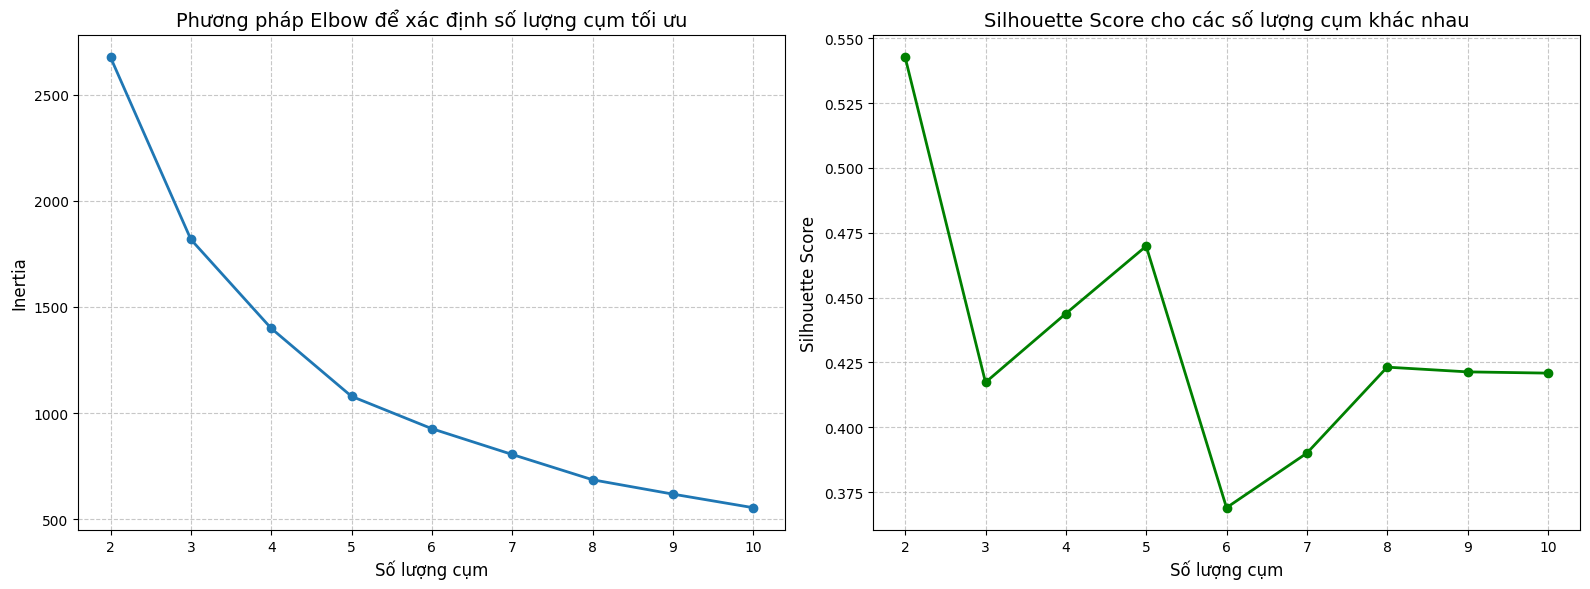

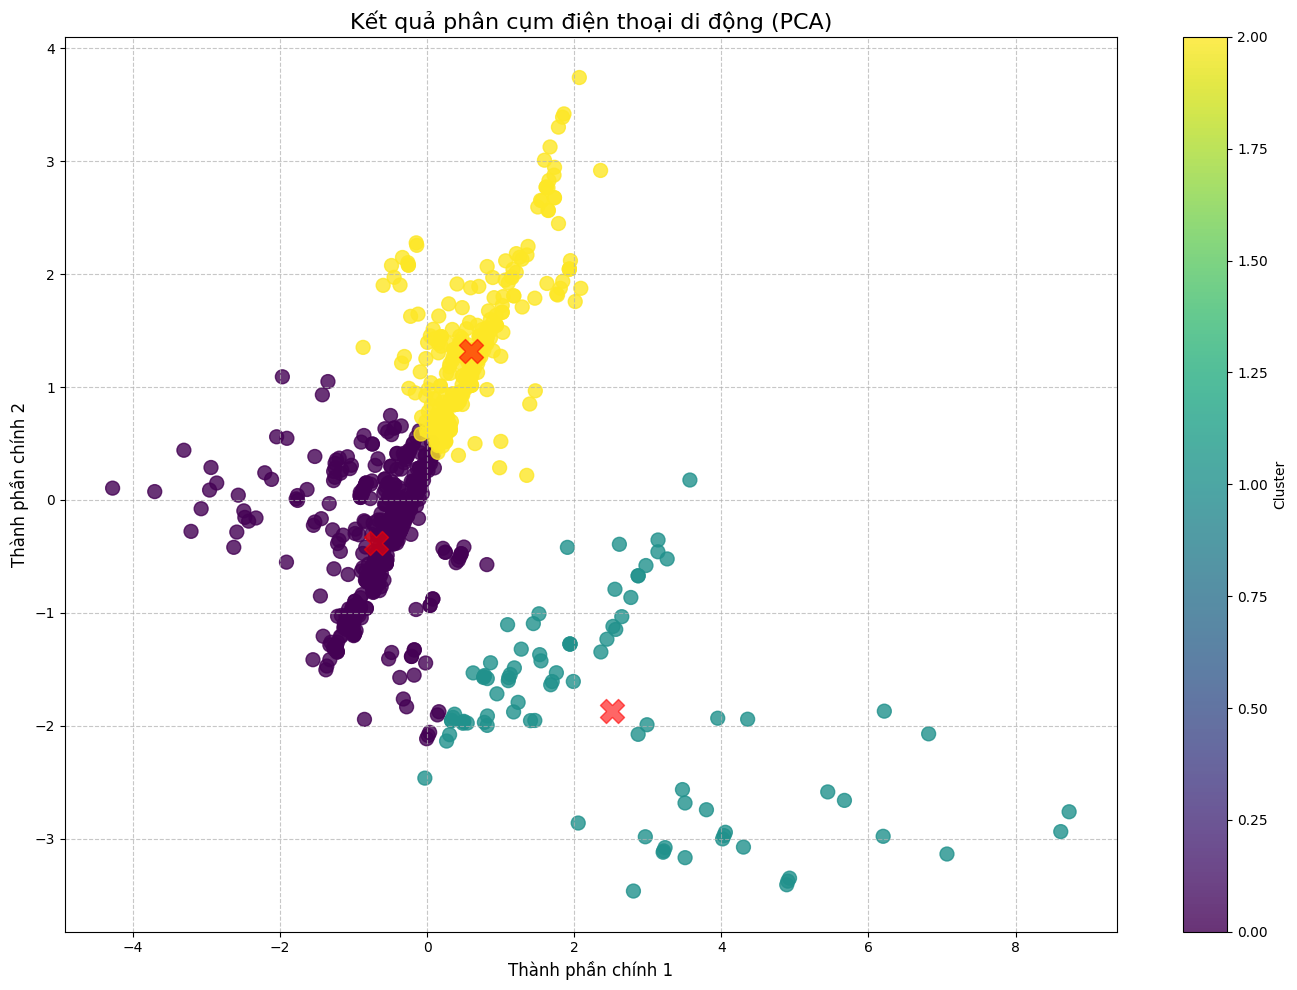

Phân tích đặc điểm của từng cụm:
             Price_PKR                                     Battery_mAh  \
                  mean    median      min       max count         mean   
Cluster                                                                  
0         76981.221429   59999.0  15999.0  309999.0   560  4903.604672   
1        124400.793103   89999.0  35000.0  399999.0    87  6283.531266   
2        221636.695069  199999.0  59999.0  604999.0   283  4955.517388   

                                                RAM_GB                    \
              median     min      max count       mean median  min   max   
Cluster                                                                    
0        5013.723212  2000.0   6400.0   560   6.140179    6.0  1.0   8.0   
1        5059.108965  5000.0  11200.0    87   7.235632    6.0  1.5  16.0   
2        5050.463917  3700.0   6400.0   283  11.208481   12.0  6.0  16.0   

              Screen_inches                            
        c

<Figure size 1400x800 with 0 Axes>

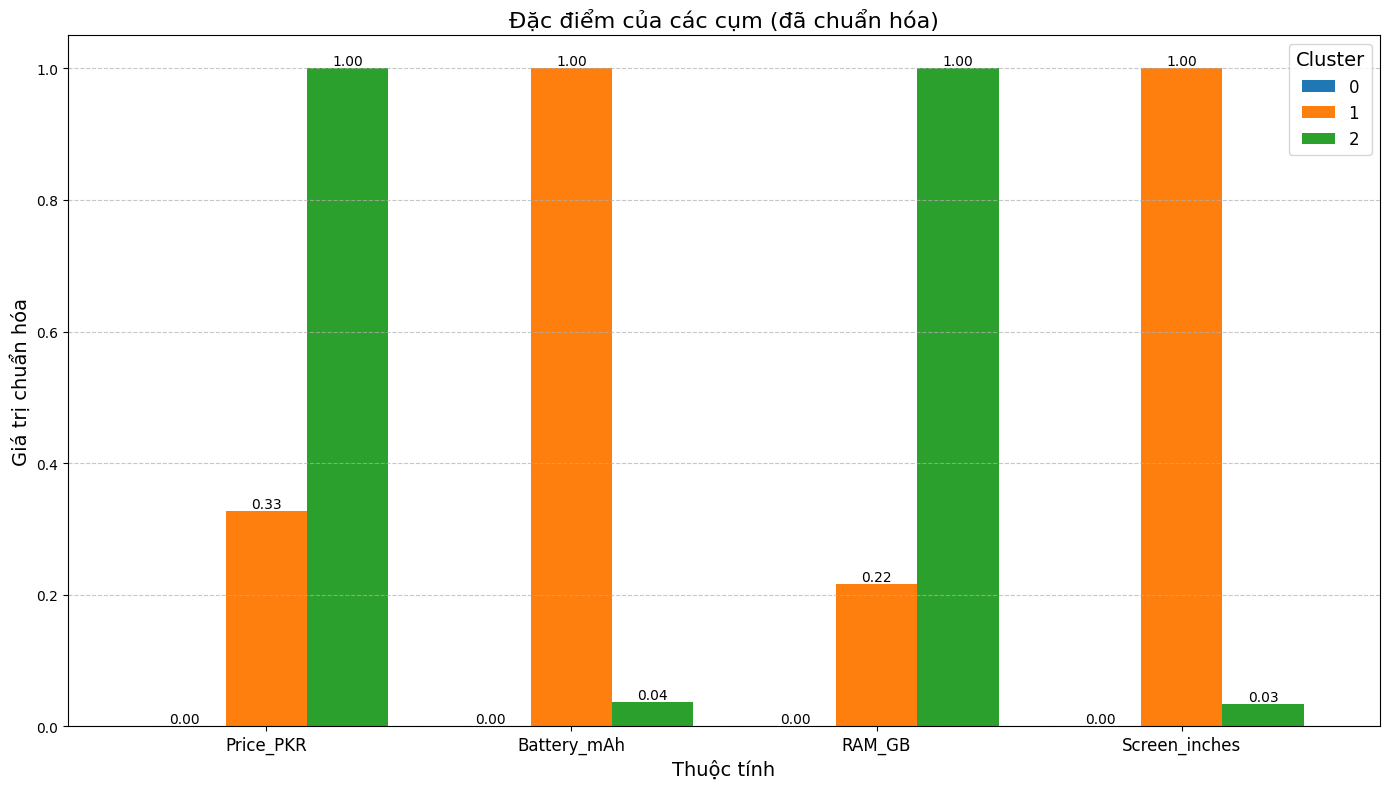

In [11]:
# Chuẩn bị dữ liệu cho phân cụm
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

# Chọn các thuộc tính cho phân cụm
cluster_features = ['Price_PKR', 'Battery_mAh', 'RAM_GB', 'Screen_inches']
cluster_data = df_processed[cluster_features].dropna()

# Chuẩn hóa dữ liệu
scaler = StandardScaler()
scaled_data = scaler.fit_transform(cluster_data)

# Xác định số lượng cụm tối ưu bằng phương pháp Elbow
inertia = []
silhouette_scores = []
k_range = range(2, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)
    
    # Tính silhouette score
    labels = kmeans.labels_
    silhouette_scores.append(silhouette_score(scaled_data, labels))

# Vẽ biểu đồ Elbow
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.plot(k_range, inertia, marker='o', linewidth=2)
plt.title('Phương pháp Elbow để xác định số lượng cụm tối ưu', fontsize=14)
plt.xlabel('Số lượng cụm', fontsize=12)
plt.ylabel('Inertia', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_scores, marker='o', linewidth=2, color='green')
plt.title('Silhouette Score cho các số lượng cụm khác nhau', fontsize=14)
plt.xlabel('Số lượng cụm', fontsize=12)
plt.ylabel('Silhouette Score', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# Chọn số lượng cụm tối ưu (giả sử là 3 dựa trên biểu đồ)
optimal_k = 3  # Điều chỉnh dựa trên kết quả biểu đồ Elbow và Silhouette

# Thực hiện phân cụm với số lượng cụm tối ưu
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(scaled_data)

# Thêm nhãn cụm vào DataFrame
cluster_data['Cluster'] = cluster_labels

# Giảm chiều dữ liệu để trực quan hóa
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)
cluster_data['PCA1'] = pca_result[:, 0]
cluster_data['PCA2'] = pca_result[:, 1]

# Trực quan hóa kết quả phân cụm
plt.figure(figsize=(14, 10))

# Vẽ biểu đồ phân cụm
plt.scatter(cluster_data['PCA1'], cluster_data['PCA2'], 
           c=cluster_data['Cluster'], cmap='viridis', s=100, alpha=0.8)
plt.title('Kết quả phân cụm điện thoại di động (PCA)', fontsize=16)
plt.xlabel('Thành phần chính 1', fontsize=12)
plt.ylabel('Thành phần chính 2', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.colorbar(label='Cluster')

# Vẽ biểu đồ trung tâm cụm
centers = kmeans.cluster_centers_
pca_centers = pca.transform(centers)
plt.scatter(pca_centers[:, 0], pca_centers[:, 1], c='red', s=300, alpha=0.6, marker='X')

plt.tight_layout()
plt.show()

# Phân tích đặc điểm của từng cụm
print("Phân tích đặc điểm của từng cụm:")
cluster_analysis = cluster_data.groupby('Cluster')[cluster_features].agg(['mean', 'median', 'min', 'max', 'count'])
print(cluster_analysis)

# Đánh giá kết quả phân cụm bằng silhouette score
silhouette_avg = silhouette_score(scaled_data, cluster_labels)
print(f"Điểm silhouette trung bình: {silhouette_avg:.3f}")

# Trực quan hóa đặc điểm của các cụm
plt.figure(figsize=(14, 8))

# Tính giá trị trung bình của các thuộc tính trong mỗi cụm
cluster_means = cluster_data.groupby('Cluster')[cluster_features].mean()

# Chuẩn hóa giá trị để so sánh
normalized_means = (cluster_means - cluster_means.min()) / (cluster_means.max() - cluster_means.min())

# Vẽ biểu đồ so sánh đặc điểm của các cụm
ax = normalized_means.T.plot(kind='bar', figsize=(14, 8), width=0.8)
plt.title('Đặc điểm của các cụm (đã chuẩn hóa)', fontsize=16)
plt.xlabel('Thuộc tính', fontsize=14)
plt.ylabel('Giá trị chuẩn hóa', fontsize=14)
plt.xticks(rotation=0, fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Cluster', fontsize=12, title_fontsize=14)

# Thêm giá trị lên đầu mỗi cột
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', fontsize=10)

plt.tight_layout()
plt.show()

Số lượng mẫu trong dữ liệu nhị phân: 930
Tổng số thuộc tính nhị phân: 27
Phân bố các thuộc tính nhị phân:
RAM_Low: 189 (20.3%)
RAM_Medium: 516 (55.5%)
RAM_High: 225 (24.2%)
Battery_Small: 7 (0.8%)
Battery_Medium: 237 (25.5%)
Battery_Large: 686 (73.8%)
Screen_Small: 35 (3.8%)
Screen_Medium: 232 (24.9%)
Screen_Large: 663 (71.3%)
Price_Budget: 77 (8.3%)
Price_Midrange: 230 (24.7%)
Price_Premium: 242 (26.0%)
Price_Ultra: 381 (41.0%)
Camera_Basic: 68 (7.3%)
Camera_Good: 360 (38.7%)
Camera_Excellent: 502 (54.0%)
FrontCam_Basic: 255 (27.4%)
FrontCam_Good: 406 (43.7%)
FrontCam_Excellent: 269 (28.9%)
Year_Old: 442 (47.5%)
Year_Recent: 184 (19.8%)
Year_New: 304 (32.7%)
Brand_Oppo: 129 (13.9%)
Brand_Apple: 97 (10.4%)
Brand_Honor: 91 (9.8%)
Brand_Samsung: 88 (9.5%)
Brand_Vivo: 86 (9.2%)

Số lượng tập phổ biến tìm được: 235
Top 10 tập phổ biến theo support:
     support                          itemsets
4   0.737634                   (Battery_Large)
6   0.712903                    (Screen_Large)
1 

/Users/baolamabcd/Workspace/project/jupyter/DKT/dkt_env/lib/python3.13/site-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


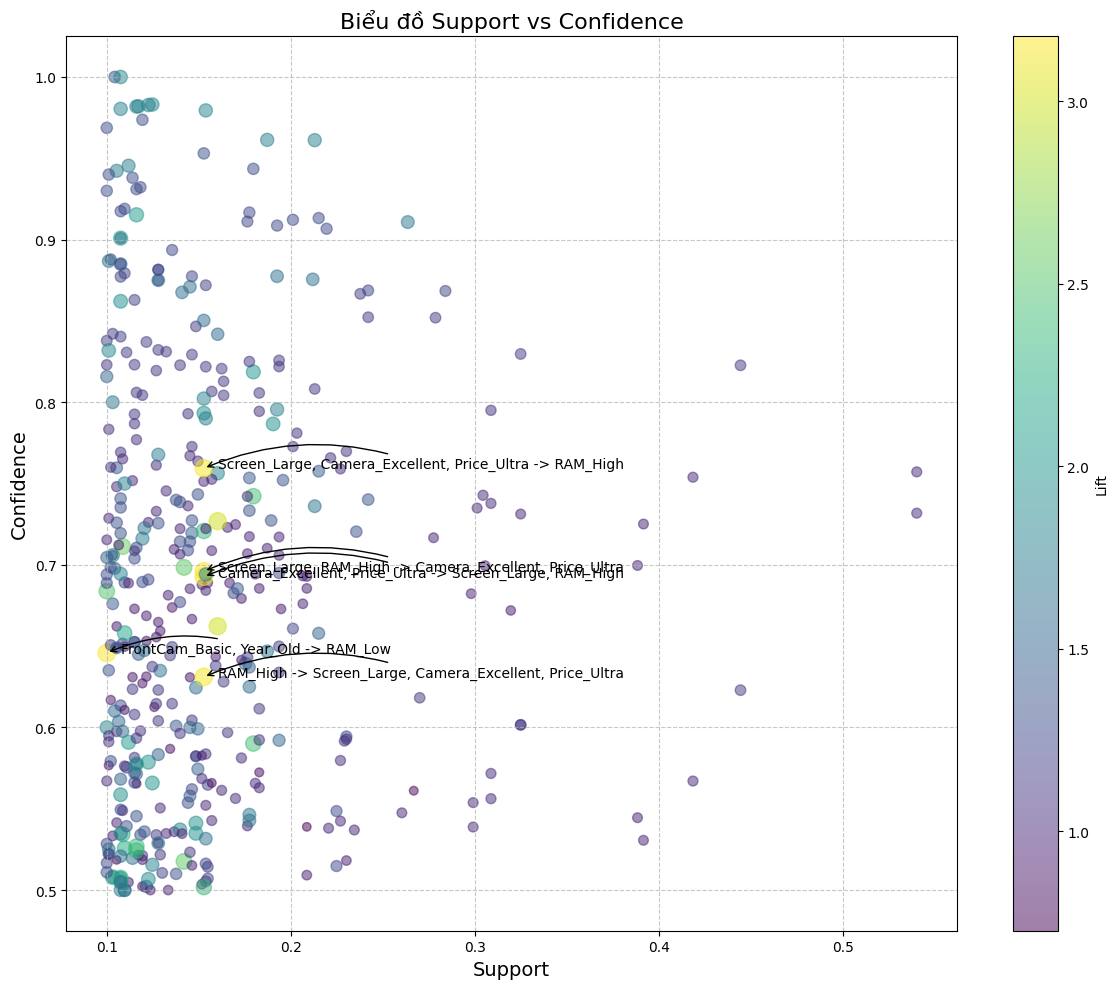


Top 10 luật theo độ đo Kulczynski:
                                           antecedents         consequents  \
421       (Screen_Large, Year_New, FrontCam_Excellent)  (Camera_Excellent)   
48                                       (Brand_Apple)     (Battery_Large)   
290                  (FrontCam_Excellent, Price_Ultra)  (Camera_Excellent)   
183                     (FrontCam_Excellent, RAM_High)  (Camera_Excellent)   
297                     (FrontCam_Excellent, Year_New)  (Camera_Excellent)   
416    (Screen_Large, FrontCam_Excellent, Price_Ultra)  (Camera_Excellent)   
371       (Screen_Large, RAM_High, FrontCam_Excellent)  (Camera_Excellent)   
395  (Screen_Large, Battery_Large, FrontCam_Excellent)  (Camera_Excellent)   
106                       (RAM_Medium, FrontCam_Basic)     (Battery_Large)   
312         (Screen_Large, RAM_Medium, FrontCam_Basic)     (Battery_Large)   

      support  confidence      lift  kulczynski  
421  0.107527    1.000000  1.852590    1.000000  
48   

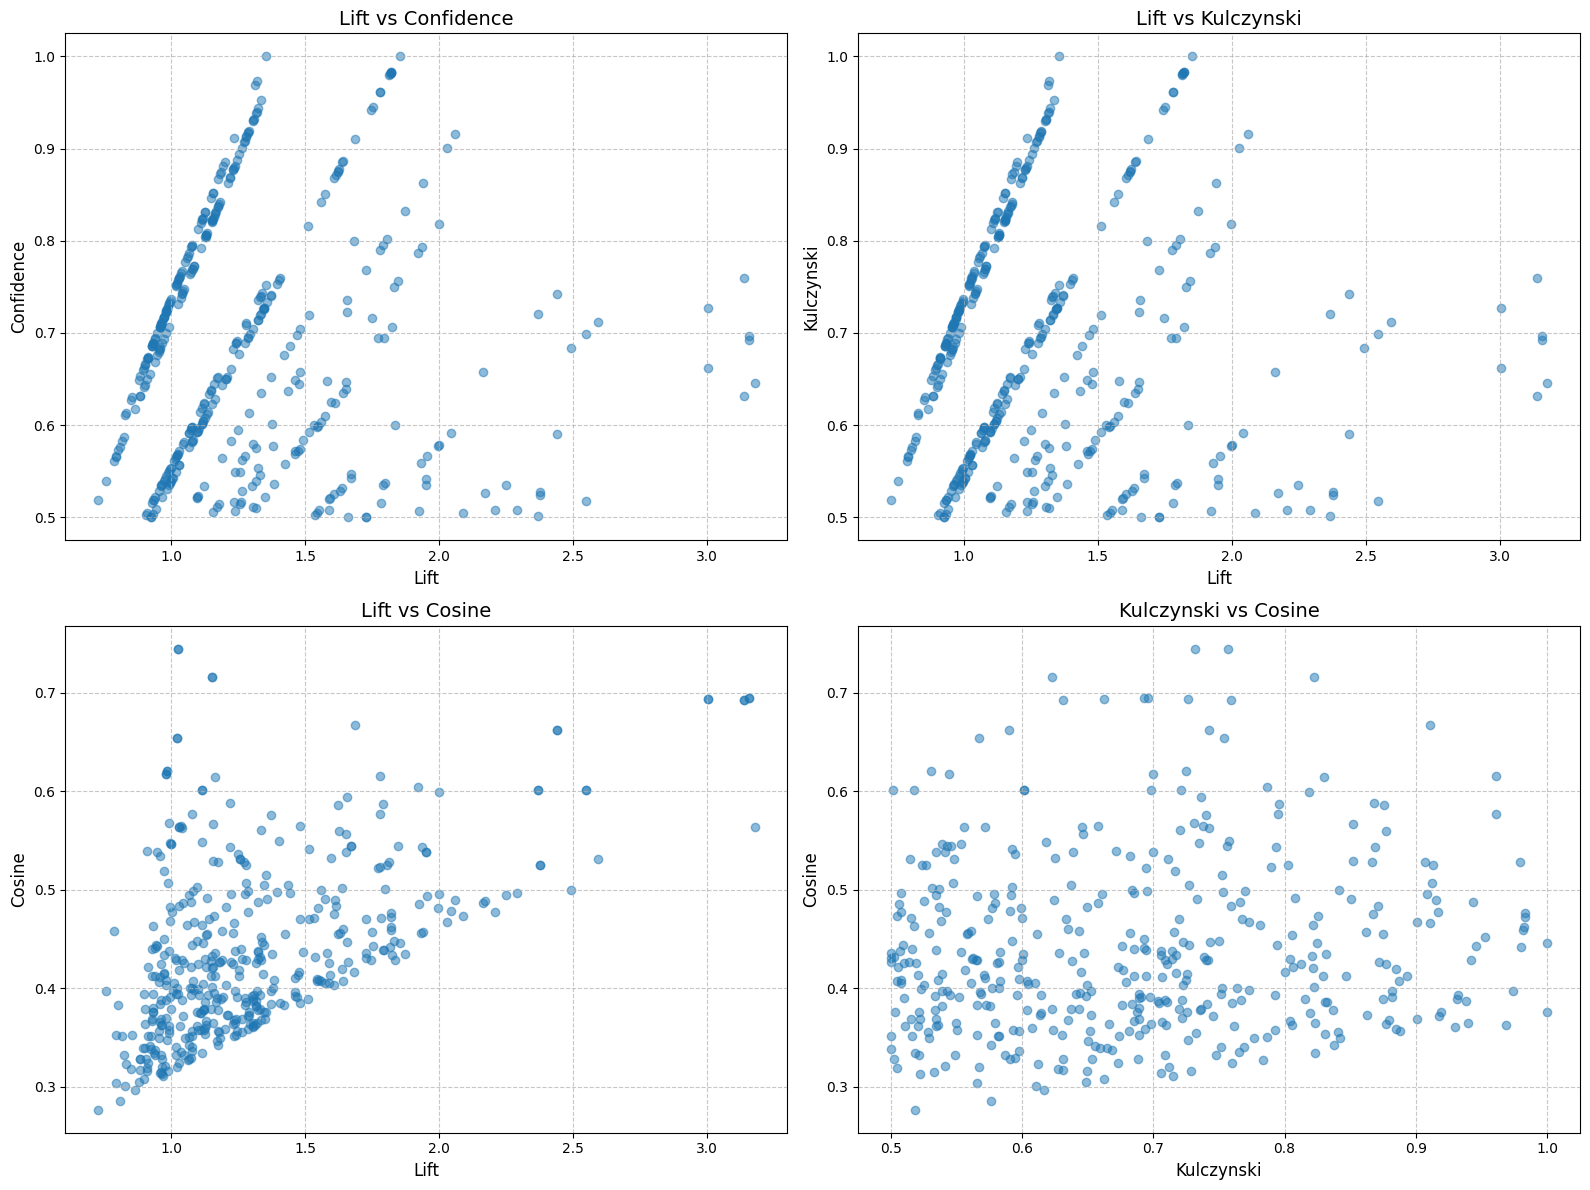


Top 10 luật có lift cao:
FrontCam_Basic, Year_Old -> RAM_Low
  Support: 0.100, Confidence: 0.646, Lift: 3.178
  Kulczynski: 0.646, Cosine: 0.564

Camera_Excellent, Price_Ultra -> Screen_Large, RAM_High
  Support: 0.153, Confidence: 0.693, Lift: 3.158
  Kulczynski: 0.693, Cosine: 0.694

Screen_Large, RAM_High -> Camera_Excellent, Price_Ultra
  Support: 0.153, Confidence: 0.696, Lift: 3.158
  Kulczynski: 0.696, Cosine: 0.694

Screen_Large, Camera_Excellent, Price_Ultra -> RAM_High
  Support: 0.153, Confidence: 0.759, Lift: 3.139
  Kulczynski: 0.759, Cosine: 0.692

RAM_High -> Screen_Large, Camera_Excellent, Price_Ultra
  Support: 0.153, Confidence: 0.631, Lift: 3.139
  Kulczynski: 0.631, Cosine: 0.692

RAM_High -> Camera_Excellent, Price_Ultra
  Support: 0.160, Confidence: 0.662, Lift: 3.004
  Kulczynski: 0.662, Cosine: 0.694

Camera_Excellent, Price_Ultra -> RAM_High
  Support: 0.160, Confidence: 0.727, Lift: 3.004
  Kulczynski: 0.727, Cosine: 0.694

RAM_Low, Battery_Large -> FrontCam_

In [12]:
# Tìm tập phổ biến và luật kết hợp
from mlxtend.frequent_patterns import apriori, association_rules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Chuẩn bị dữ liệu cho tìm tập phổ biến
# Tạo các thuộc tính nhị phân
df_binary = pd.DataFrame()

# Phân loại RAM
df_binary['RAM_Low'] = (df_processed['RAM_GB'] <= 4).astype(int)
df_binary['RAM_Medium'] = ((df_processed['RAM_GB'] > 4) & (df_processed['RAM_GB'] <= 8)).astype(int)
df_binary['RAM_High'] = (df_processed['RAM_GB'] > 8).astype(int)

# Phân loại pin
df_binary['Battery_Small'] = (df_processed['Battery_mAh'] <= 3000).astype(int)
df_binary['Battery_Medium'] = ((df_processed['Battery_mAh'] > 3000) & (df_processed['Battery_mAh'] <= 5000)).astype(int)
df_binary['Battery_Large'] = (df_processed['Battery_mAh'] > 5000).astype(int)

# Phân loại màn hình
df_binary['Screen_Small'] = (df_processed['Screen_inches'] <= 6).astype(int)
df_binary['Screen_Medium'] = ((df_processed['Screen_inches'] > 6) & (df_processed['Screen_inches'] <= 6.5)).astype(int)
df_binary['Screen_Large'] = (df_processed['Screen_inches'] > 6.5).astype(int)

# Phân loại giá
df_binary['Price_Budget'] = (df_processed['Price_PKR'] <= 30000).astype(int)
df_binary['Price_Midrange'] = ((df_processed['Price_PKR'] > 30000) & (df_processed['Price_PKR'] <= 60000)).astype(int)
df_binary['Price_Premium'] = ((df_processed['Price_PKR'] > 60000) & (df_processed['Price_PKR'] <= 100000)).astype(int)
df_binary['Price_Ultra'] = (df_processed['Price_PKR'] > 100000).astype(int)

# Phân loại camera sau
df_binary['Camera_Basic'] = (df_processed['Back_Camera_MP'] <= 12).astype(int)
df_binary['Camera_Good'] = ((df_processed['Back_Camera_MP'] > 12) & (df_processed['Back_Camera_MP'] <= 48)).astype(int)
df_binary['Camera_Excellent'] = (df_processed['Back_Camera_MP'] > 48).astype(int)

# Phân loại camera trước
df_binary['FrontCam_Basic'] = (df_processed['Front_Camera_MP'] <= 8).astype(int)
df_binary['FrontCam_Good'] = ((df_processed['Front_Camera_MP'] > 8) & (df_processed['Front_Camera_MP'] <= 16)).astype(int)
df_binary['FrontCam_Excellent'] = (df_processed['Front_Camera_MP'] > 16).astype(int)

# Phân loại năm ra mắt
df_binary['Year_Old'] = (pd.to_numeric(df_processed['Launched Year'], errors='coerce') <= 2022).astype(int)
df_binary['Year_Recent'] = ((pd.to_numeric(df_processed['Launched Year'], errors='coerce') > 2022) & 
                           (pd.to_numeric(df_processed['Launched Year'], errors='coerce') <= 2023)).astype(int)
df_binary['Year_New'] = (pd.to_numeric(df_processed['Launched Year'], errors='coerce') > 2023).astype(int)

# Thêm thông tin về hãng sản xuất (top 5 hãng)
top5_brands = df_processed['Company Name'].value_counts().nlargest(5).index
for brand in top5_brands:
    df_binary[f'Brand_{brand}'] = (df_processed['Company Name'] == brand).astype(int)

# Loại bỏ các hàng có giá trị NaN
df_binary = df_binary.dropna()

# Kiểm tra dữ liệu nhị phân
print("Số lượng mẫu trong dữ liệu nhị phân:", len(df_binary))
print("Tổng số thuộc tính nhị phân:", len(df_binary.columns))
print("Phân bố các thuộc tính nhị phân:")
for col in df_binary.columns:
    count = df_binary[col].sum()
    percentage = count / len(df_binary) * 100
    print(f"{col}: {count} ({percentage:.1f}%)")

# Tìm tập phổ biến
frequent_itemsets = apriori(df_binary, min_support=0.1, use_colnames=True)
print("\nSố lượng tập phổ biến tìm được:", len(frequent_itemsets))
print("Top 10 tập phổ biến theo support:")
print(frequent_itemsets.sort_values('support', ascending=False).head(10))

# Tạo luật kết hợp
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.5)
print("\nSố lượng luật kết hợp tìm được:", len(rules))
print("Top 10 luật kết hợp theo confidence:")
print(rules.sort_values('confidence', ascending=False).head(10))

# Trực quan hóa luật kết hợp
plt.figure(figsize=(12, 10))
plt.scatter(rules['support'], rules['confidence'], alpha=0.5, s=rules['lift']*50, c=rules['lift'], cmap='viridis')
plt.colorbar(label='Lift')
plt.xlabel('Support', fontsize=14)
plt.ylabel('Confidence', fontsize=14)
plt.title('Biểu đồ Support vs Confidence', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.7)

# Thêm chú thích cho một số luật quan trọng
for i, rule in rules.sort_values('lift', ascending=False).head(5).iterrows():
    antecedents = ', '.join(list(rule['antecedents']))
    consequents = ', '.join(list(rule['consequents']))
    plt.annotate(f"{antecedents} -> {consequents}", 
                 xy=(rule['support'], rule['confidence']), 
                 xytext=(10, 0), textcoords='offset points', 
                 arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=.2'))

plt.tight_layout()
plt.show()

# Đánh giá luật kết hợp bằng các độ đo khác nhau
# Tính toán các độ đo bổ sung
rules['all_confidence'] = rules['support'] / rules[['antecedent support', 'consequent support']].max(axis=1)
rules['max_confidence'] = rules[['confidence', 'lift']].max(axis=1)
rules['kulczynski'] = (rules['confidence'] + rules['confidence']) / 2
rules['cosine'] = rules['support'] / np.sqrt(rules['antecedent support'] * rules['consequent support'])

# Hiển thị top 10 luật theo độ đo Kulczynski
print("\nTop 10 luật theo độ đo Kulczynski:")
print(rules.sort_values('kulczynski', ascending=False).head(10)[['antecedents', 'consequents', 'support', 'confidence', 'lift', 'kulczynski']])

# Hiển thị top 10 luật theo độ đo Cosine
print("\nTop 10 luật theo độ đo Cosine:")
print(rules.sort_values('cosine', ascending=False).head(10)[['antecedents', 'consequents', 'support', 'confidence', 'lift', 'cosine']])

# So sánh các độ đo
plt.figure(figsize=(16, 12))

plt.subplot(2, 2, 1)
plt.scatter(rules['lift'], rules['confidence'], alpha=0.5)
plt.xlabel('Lift', fontsize=12)
plt.ylabel('Confidence', fontsize=12)
plt.title('Lift vs Confidence', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)

plt.subplot(2, 2, 2)
plt.scatter(rules['lift'], rules['kulczynski'], alpha=0.5)
plt.xlabel('Lift', fontsize=12)
plt.ylabel('Kulczynski', fontsize=12)
plt.title('Lift vs Kulczynski', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)

plt.subplot(2, 2, 3)
plt.scatter(rules['lift'], rules['cosine'], alpha=0.5)
plt.xlabel('Lift', fontsize=12)
plt.ylabel('Cosine', fontsize=12)
plt.title('Lift vs Cosine', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)

plt.subplot(2, 2, 4)
plt.scatter(rules['kulczynski'], rules['cosine'], alpha=0.5)
plt.xlabel('Kulczynski', fontsize=12)
plt.ylabel('Cosine', fontsize=12)
plt.title('Kulczynski vs Cosine', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# Phân tích các luật kết hợp quan trọng
# Lọc các luật có lift cao
high_lift_rules = rules[rules['lift'] > 1.5].sort_values('lift', ascending=False)

# Hiển thị top 10 luật có lift cao
print("\nTop 10 luật có lift cao:")
for i, rule in high_lift_rules.head(10).iterrows():
    antecedents = ', '.join(list(rule['antecedents']))
    consequents = ', '.join(list(rule['consequents']))
    print(f"{antecedents} -> {consequents}")
    print(f"  Support: {rule['support']:.3f}, Confidence: {rule['confidence']:.3f}, Lift: {rule['lift']:.3f}")
    print(f"  Kulczynski: {rule['kulczynski']:.3f}, Cosine: {rule['cosine']:.3f}")
    print()

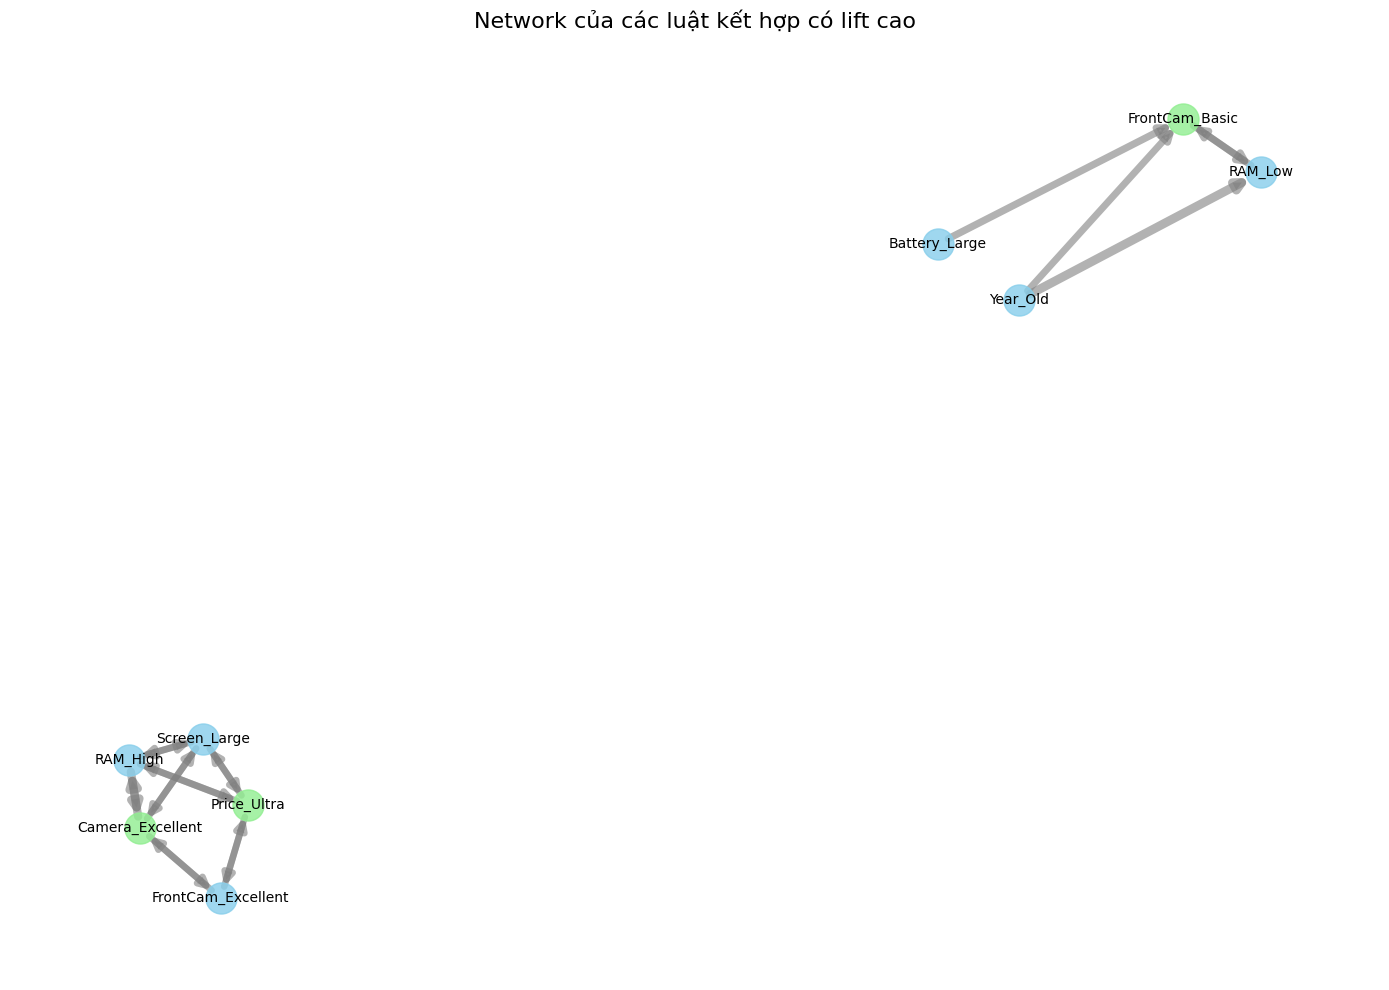

In [14]:
# Vẽ biểu đồ network cho các luật kết hợp
import networkx as nx

# Tạo đồ thị
G = nx.DiGraph()

# Thêm các nút và cạnh từ các luật kết hợp
for i, rule in high_lift_rules.head(15).iterrows():
    for antecedent in rule['antecedents']:
        G.add_node(antecedent, type='antecedent')
        for consequent in rule['consequents']:
            G.add_node(consequent, type='consequent')
            G.add_edge(antecedent, consequent, weight=rule['lift'], confidence=rule['confidence'])

# Vẽ đồ thị
plt.figure(figsize=(14, 10))
pos = nx.spring_layout(G, seed=42)

# Vẽ các nút
antecedent_nodes = [node for node, attr in G.nodes(data=True) if attr.get('type') == 'antecedent']
consequent_nodes = [node for node, attr in G.nodes(data=True) if attr.get('type') == 'consequent']

nx.draw_networkx_nodes(G, pos, nodelist=antecedent_nodes, node_color='skyblue', node_size=500, alpha=0.8)
nx.draw_networkx_nodes(G, pos, nodelist=consequent_nodes, node_color='lightgreen', node_size=500, alpha=0.8)

# Vẽ các cạnh với độ dày tỷ lệ với lift
edges = G.edges(data=True)
weights = [data['weight'] * 2 for _, _, data in edges]
nx.draw_networkx_edges(G, pos, width=weights, edge_color='gray', alpha=0.6, arrows=True, arrowsize=15)

# Thêm nhãn
nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif')

plt.title('Network của các luật kết hợp có lift cao', fontsize=16)
plt.axis('off')
plt.tight_layout()
plt.show()